In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA

from pyspark.ml.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.util import MLUtils
import numpy as np
from pyspark.ml.feature import StandardScaler
import pandas as pd
from pyspark.sql import Row

from pyspark.ml.stat import Correlation
from pyspark.ml.stat import ChiSquareTest

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier


from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
spark=SparkSession.builder.appName('big_data_analytics').getOrCreate()

In [3]:
spark

In [4]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [5]:
schema=StructType()\
.add("srcip","string")\
.add("sport","integer")\
.add("dstip","string")\
.add("dsport","integer")\
.add("proto","string")\
.add("state","string")\
.add("dur","float")\
.add("sbytes","integer")\
.add("dbytes","integer")\
.add("sttl","integer")\
.add("dttl","integer")\
.add("sloss","integer")\
.add("dloss","integer")\
.add("service","string")\
.add("Sload","float")\
.add("Dload","float")\
.add("Spkts","integer")\
.add("Dpkts","integer")\
.add("swin","integer")\
.add("dwin","integer")\
.add("stcpb","integer")\
.add("dtcpb","integer")\
.add("smeansz","integer")\
.add("dmeansz","integer")\
.add("trans_depth","integer")\
.add("res_bdy_len","integer")\
.add("Sjit","float")\
.add("Djit","float")\
.add("Stime","integer")\
.add("Ltime","integer")\
.add("Sintpkt","float")\
.add("Dintpkt","float")\
.add("tcprtt","float")\
.add("synack","float")\
.add("ackdat","float")\
.add("is_sm_ips_ports","integer")\
.add("ct_state_ttl","integer")\
.add("ct_flw_http_mthd","integer")\
.add("is_ftp_login","integer")\
.add("ct_ftp_cmd","integer")\
.add("ct_srv_src","integer")\
.add("ct_srv_dst","integer")\
.add("ct_dst_ltm","integer")\
.add("ct_src_ ltm","integer")\
.add("ct_src_dport_ltm","integer")\
.add("ct_dst_sport_ltm","integer")\
.add("ct_dst_src_ltm","integer")\
.add("attack_cat","string")\
.add("Label","integer")

In [6]:
df=spark.read.csv("hdfs://spark:9000/data/UNSW-NB15.csv",schema=schema)
df.printSchema()

root
 |-- srcip: string (nullable = true)
 |-- sport: integer (nullable = true)
 |-- dstip: string (nullable = true)
 |-- dsport: integer (nullable = true)
 |-- proto: string (nullable = true)
 |-- state: string (nullable = true)
 |-- dur: float (nullable = true)
 |-- sbytes: integer (nullable = true)
 |-- dbytes: integer (nullable = true)
 |-- sttl: integer (nullable = true)
 |-- dttl: integer (nullable = true)
 |-- sloss: integer (nullable = true)
 |-- dloss: integer (nullable = true)
 |-- service: string (nullable = true)
 |-- Sload: float (nullable = true)
 |-- Dload: float (nullable = true)
 |-- Spkts: integer (nullable = true)
 |-- Dpkts: integer (nullable = true)
 |-- swin: integer (nullable = true)
 |-- dwin: integer (nullable = true)
 |-- stcpb: integer (nullable = true)
 |-- dtcpb: integer (nullable = true)
 |-- smeansz: integer (nullable = true)
 |-- dmeansz: integer (nullable = true)
 |-- trans_depth: integer (nullable = true)
 |-- res_bdy_len: integer (nullable = true)
 |-

### Data Exploration and visualisation

In [7]:
print("Size of the dataset: ", df.count())

Size of the dataset:  2539739


In [8]:
#show the first 5 rows
df.show(5)

22/01/09 01:21:25 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+-----+-------------+------+-----+-----+--------+------+------+----+----+-----+-----+-------+---------+---------+-----+-----+----+----+---------+----------+-------+-------+-----------+-----------+---------+---------+----------+----------+---------+--------+-------+-------+-------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+
|     srcip|sport|        dstip|dsport|proto|state|     dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|    Sload|    Dload|Spkts|Dpkts|swin|dwin|    stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|     Sjit|     Djit|     Stime|     Ltime|  Sintpkt| Dintpkt| tcprtt| synack| ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+----------+-----+-------------+------+-----+-----+-

In [9]:
#get a random sample of the data
df.sample(0.0005, 100).show(5)

+----------+-----+-------------+------+-----+-----+--------+------+------+----+----+-----+-----+-------+---------+-----------+-----+-----+----+----+---------+---------+-------+-------+-----------+-----------+---------+---------+----------+----------+--------+--------+-------+-------+-------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+
|     srcip|sport|        dstip|dsport|proto|state|     dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|    Sload|      Dload|Spkts|Dpkts|swin|dwin|    stcpb|    dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|     Sjit|     Djit|     Stime|     Ltime| Sintpkt| Dintpkt| tcprtt| synack| ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+----------+-----+-------------+------+-----+-----+-

### Exploring categorical features

We are interested to identify the quantities of categories, 
therefore identify the category with the highet or lowest category.
we can also sort by categories.

In [10]:
#let check the souce ip and destination ip
print("Unique source IP: ", len(df.select("srcip").toPandas()['srcip'].unique()))
print("Unique destination IP: ", len(df.select("dstip").toPandas()['dstip'].unique()))

Unique source IP:  43


Unique destination IP:  47


In [11]:
#Let's regroup cases by source ip
data = df.groupBy('srcip').count().sort("count", ascending=False).toPandas()
data.head(5)

,srcip,count
0,59.166.0.4,197959
1,59.166.0.1,197680
2,59.166.0.5,197626
3,59.166.0.2,197550
4,59.166.0.0,197528


In [12]:
#Let's regroup cases by destination ip
data2 = df.groupBy('dstip').count().sort("count", ascending=False).toPandas()
data2.head(5)

,dstip,count
0,149.171.126.3,197771
1,149.171.126.2,197648
2,149.171.126.4,197639
3,149.171.126.1,197535
4,149.171.126.5,197000


/tmp/ipykernel_427246/3968538131.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(srcip, fontsize= 14, fontweight='bold')


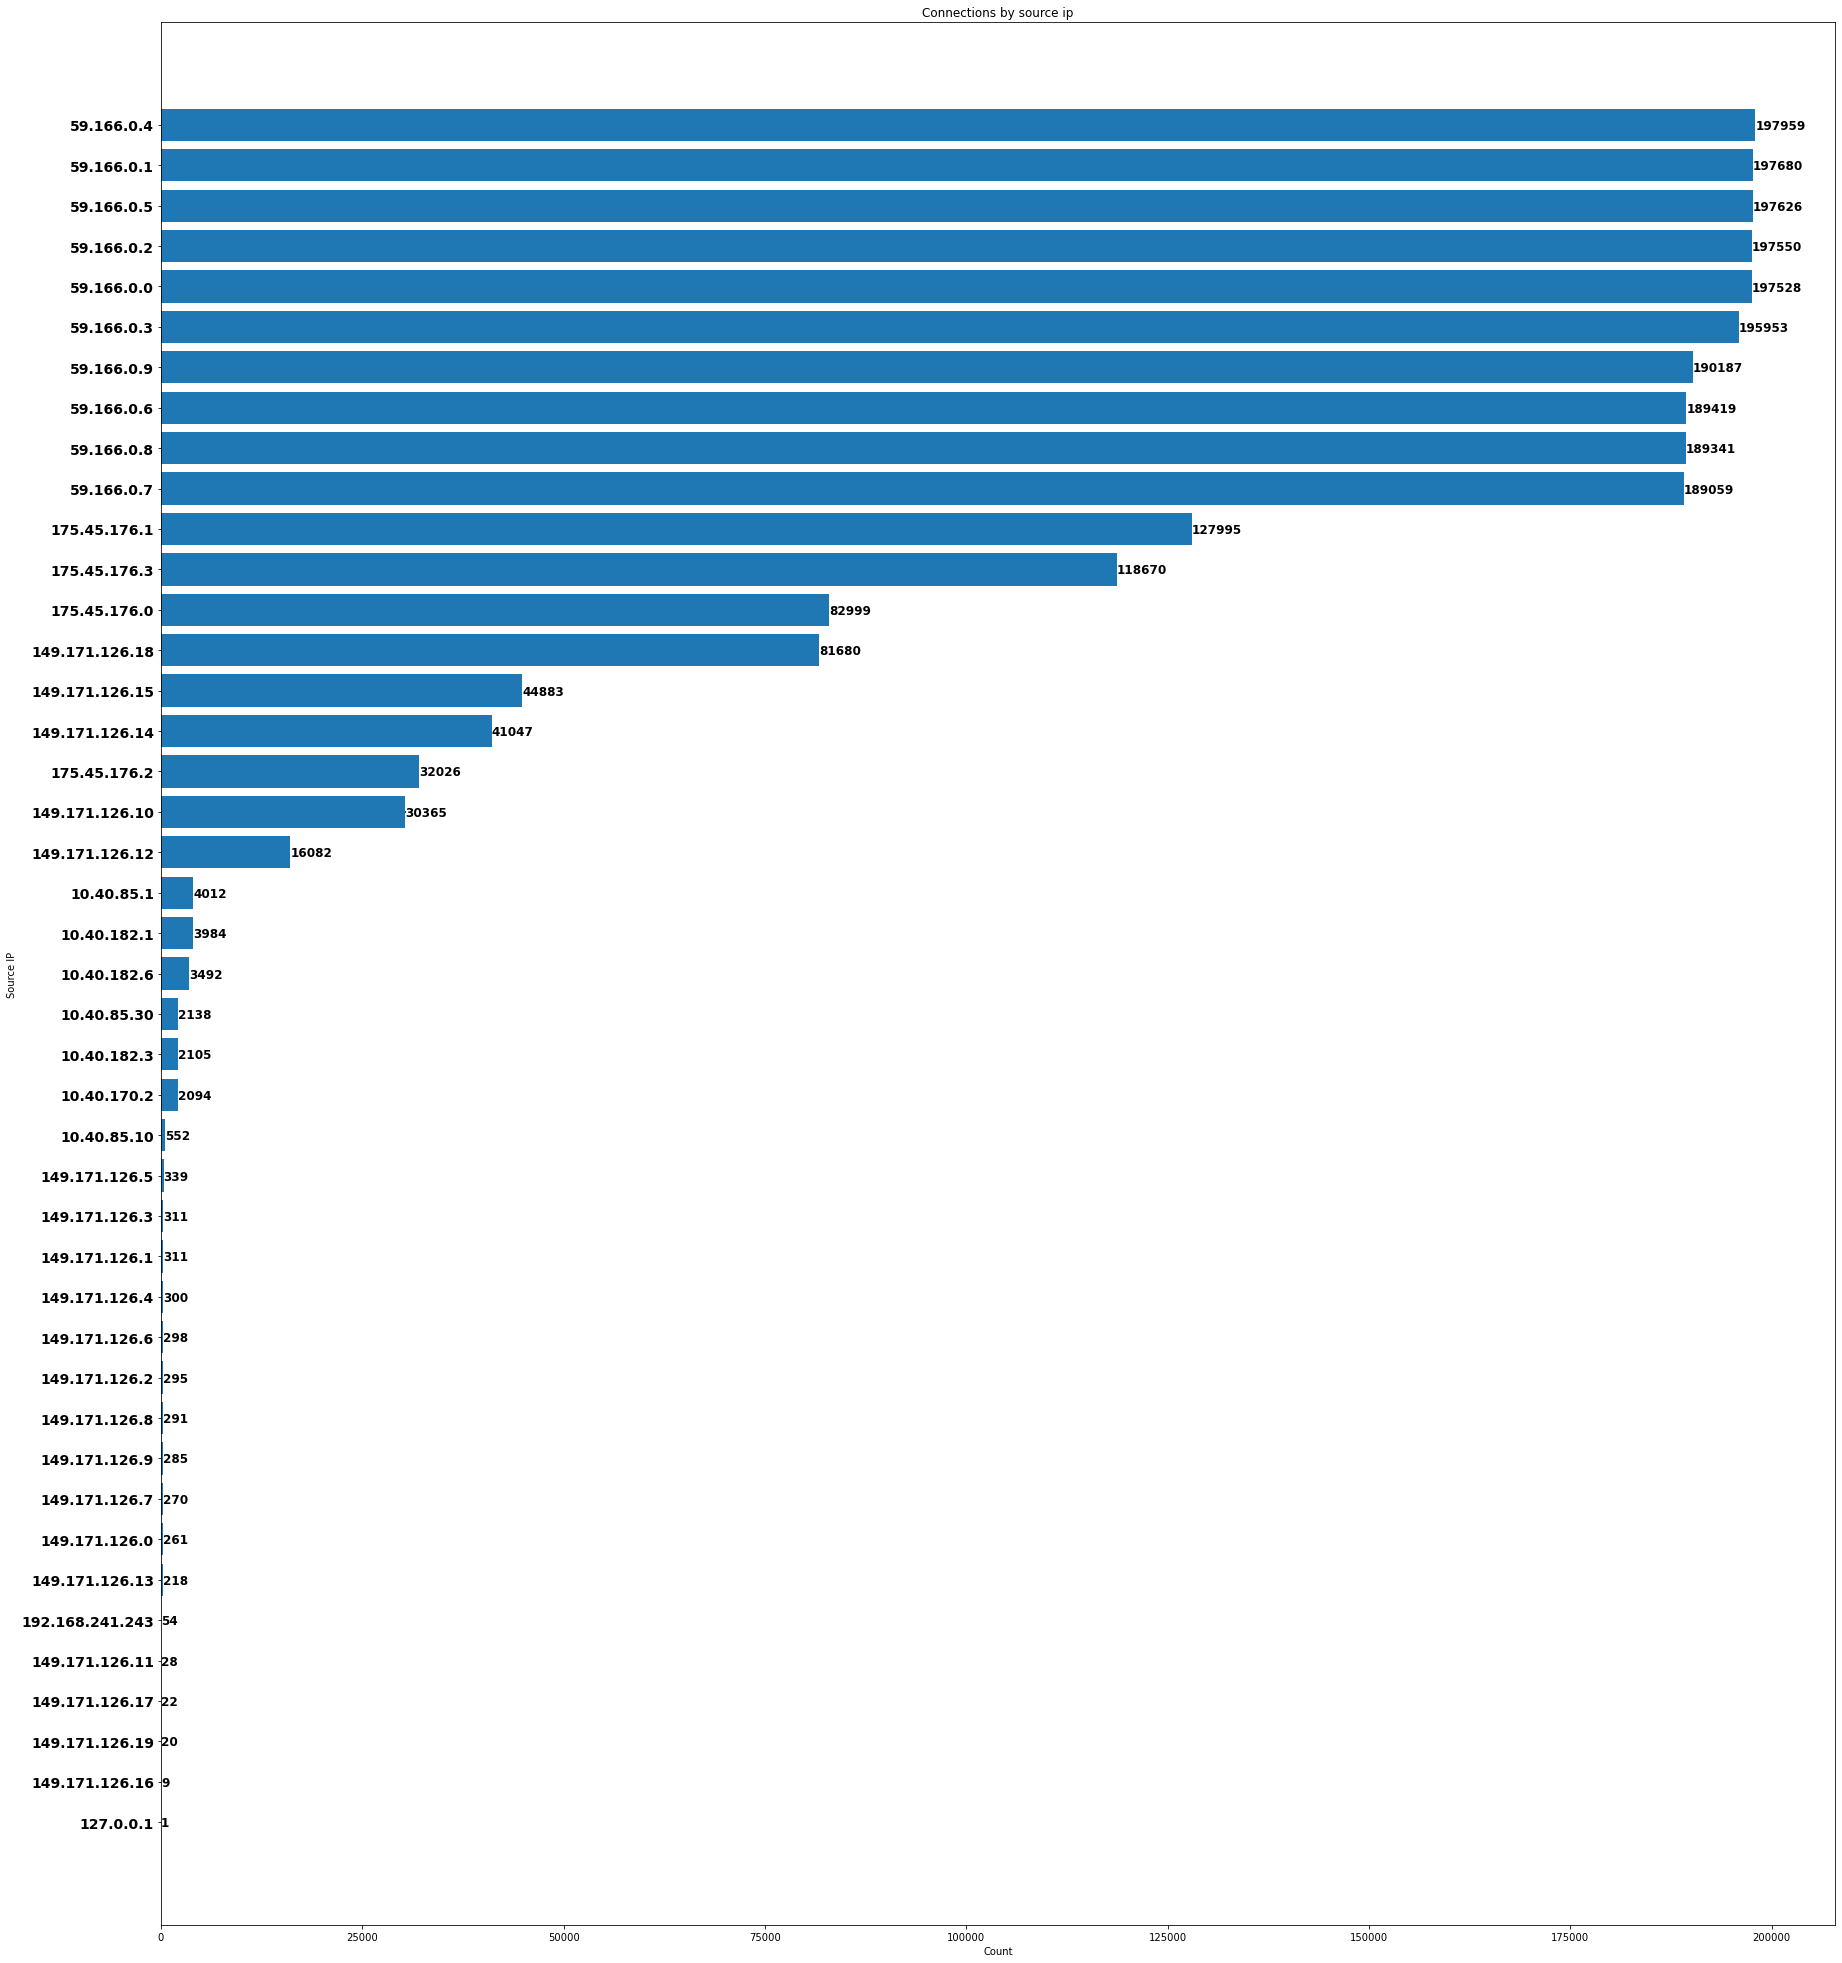

In [13]:
fig = plt.figure(figsize=(30,35))

ax = fig.subplots()

srcip = data['srcip']
y_pos = np.arange(len(srcip))
values = data['count']

error = np.random.rand(len(srcip))

ax.barh(y_pos, values, xerr=error, align='center')
ax.set_yticklabels(srcip, fontsize= 14, fontweight='bold') 

ax.set_yticks(y_pos)

ax.invert_yaxis()  
ax.set_xlabel('Count')
ax.set_ylabel('Source IP')
ax.set_title('Connections by source ip')

for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 12, fontweight ='bold',
             color ='black')
plt.show()

/tmp/ipykernel_427246/3452558713.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(srcip, fontsize= 14, fontweight='bold')


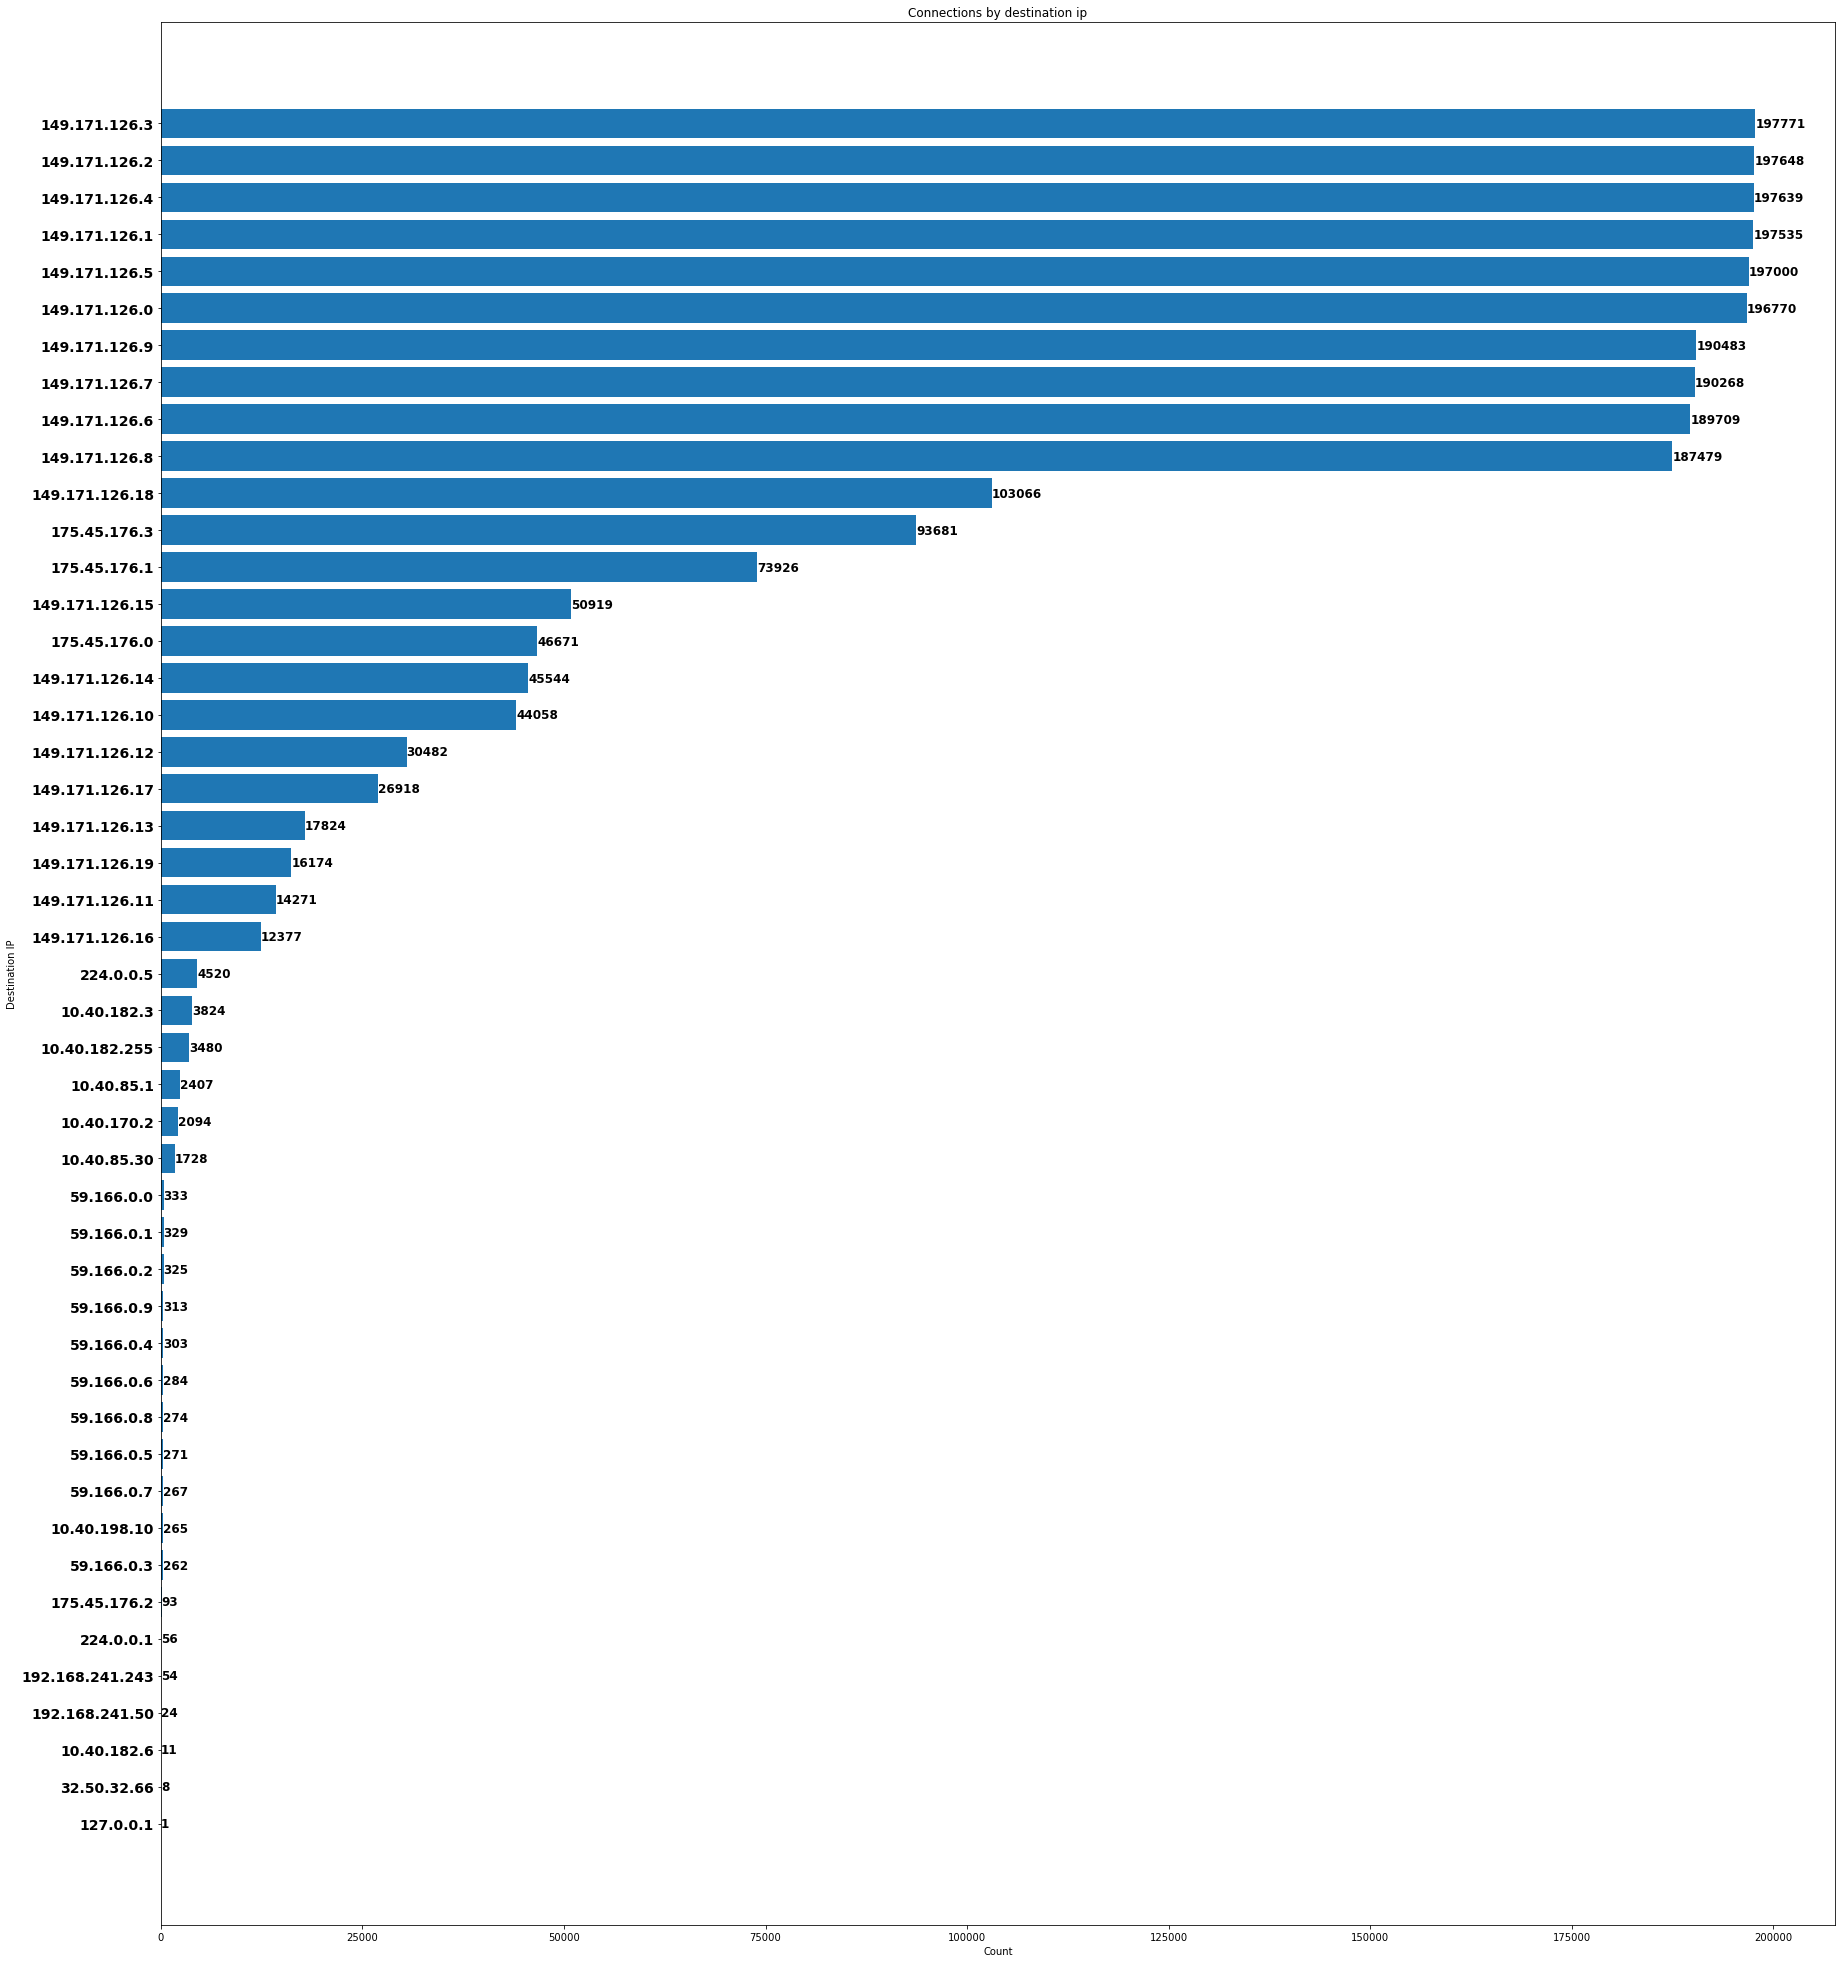

In [14]:
fig = plt.figure(figsize=(30,35))

ax = fig.subplots()

srcip = data2['dstip']
y_pos = np.arange(len(srcip))
values = data2['count']

error = np.random.rand(len(srcip))

ax.barh(y_pos, values, xerr=error, align='center')
ax.set_yticklabels(srcip, fontsize= 14, fontweight='bold') 

ax.set_yticks(y_pos)

ax.invert_yaxis()  
ax.set_xlabel('Count')
ax.set_ylabel('Destination IP')
ax.set_title('Connections by destination ip')

for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 12, fontweight ='bold',
             color ='black')
plt.show()

In [15]:
#Let's regroup ip by attack and normal
data = df.groupBy('srcip').agg(F.count(F.when(F.col('Label') == 1, 1)).alias('Attack'),
                       F.count(F.when(F.col('Label') == 0, 1)).alias('Normal')).toPandas()
data.head(5)

,srcip,Attack,Normal
0,149.171.126.16,0,9
1,59.166.0.5,0,197626
2,10.40.170.2,0,2094
3,59.166.0.8,0,189341
4,10.40.85.1,0,4012


In [16]:
#Let's regroup ip by attack and normal
data2 = df.groupBy('dstip').agg(F.count(F.when(F.col('Label') == 1, 1)).alias('Attack'),
                       F.count(F.when(F.col('Label') == 0, 1)).alias('Normal')).toPandas()
data2.head(5)

,dstip,Attack,Normal
0,149.171.126.16,7428,4949
1,59.166.0.5,0,271
2,10.40.170.2,0,2094
3,59.166.0.8,0,274
4,10.40.85.1,0,2407


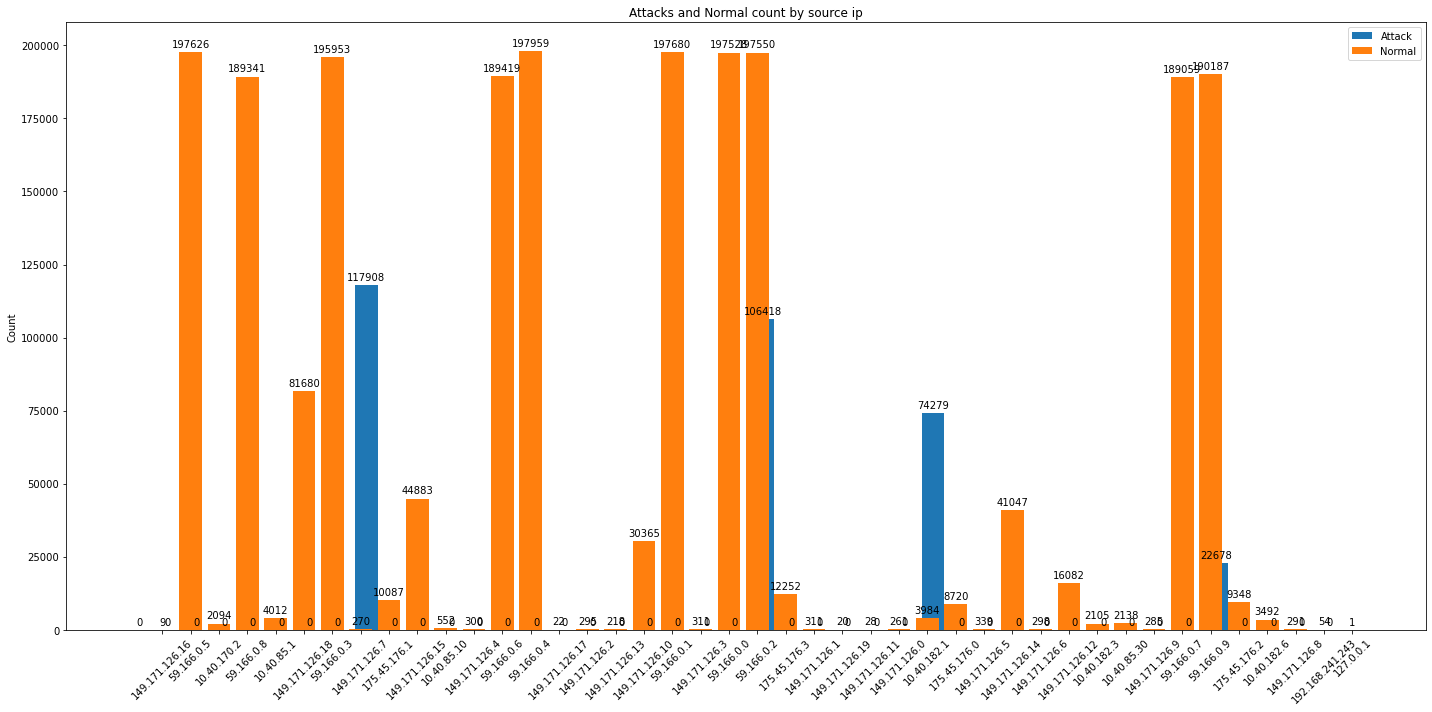

In [17]:
labels = data['srcip']
attack = data['Attack']
normal = data['Normal']

fig = plt.figure(figsize=(20,10))

x = np.arange(len(labels))  # the label locations
width = 0.8  # the width of the bars

ax = fig.subplots()
rects1 = ax.bar(x - width/2, attack, width, label='Attack')
rects2 = ax.bar(x + width/2, normal, width, label='Normal')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Attacks and Normal count by source ip')
plt.xticks(rotation=45)
ax.set_xticks(x + width / 2)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

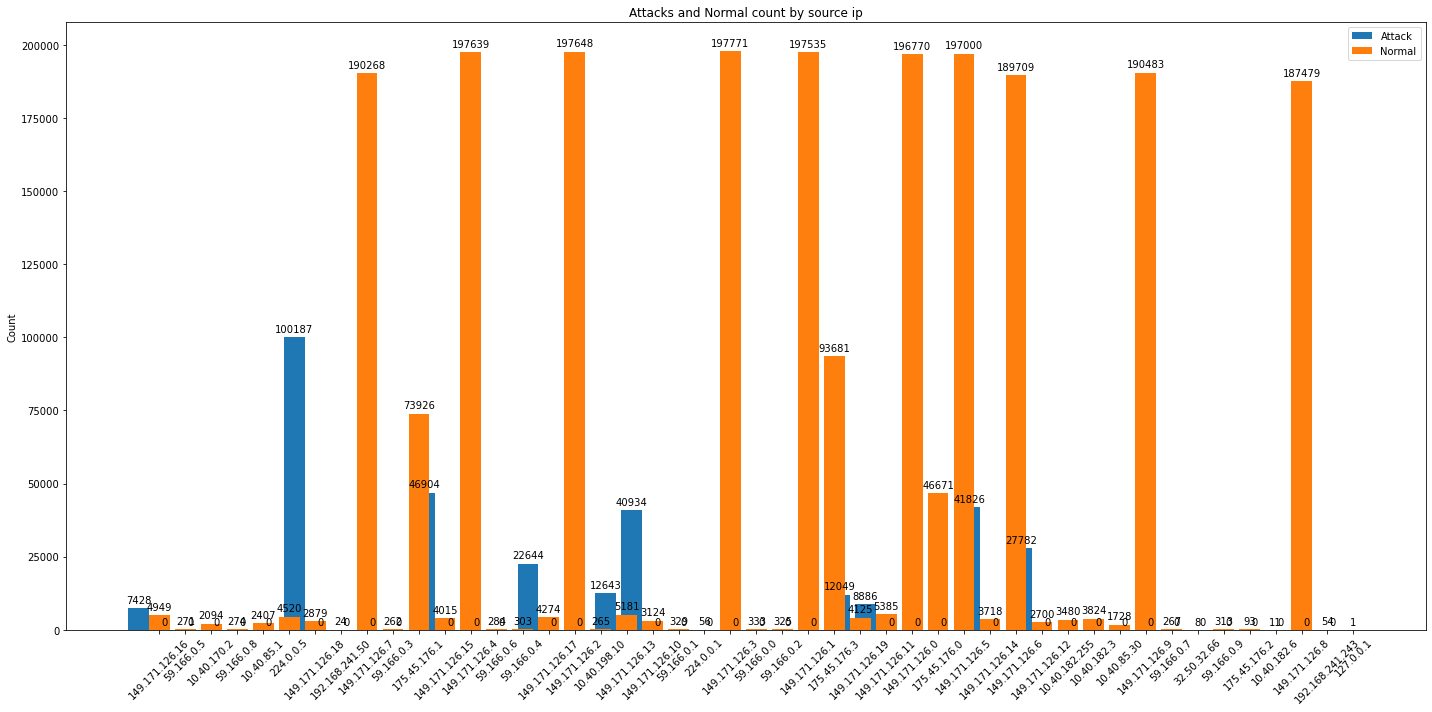

In [18]:
labels = data2['dstip']
attack = data2['Attack']
normal = data2['Normal']

fig = plt.figure(figsize=(20,10))

x = np.arange(len(labels))  # the label locations
width = 0.8  # the width of the bars

ax = fig.subplots()
rects1 = ax.bar(x - width/2, attack, width, label='Attack')
rects2 = ax.bar(x + width/2, normal, width, label='Normal')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Attacks and Normal count by source ip')
plt.xticks(rotation=45)
ax.set_xticks(x + width / 2)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [19]:
print("Number of category: ", df.groupBy('state').count().count())

Number of category:  16


In [20]:
#Exploring the state column
data = df.groupBy('state').count().toPandas()
data

,state,count
0,URN,7
1,ACC,43
2,ECO,96
3,ECR,8
4,PAR,26
5,RST,528
6,REQ,9043
7,FIN,1478689
8,INT,490469
9,MAS,7


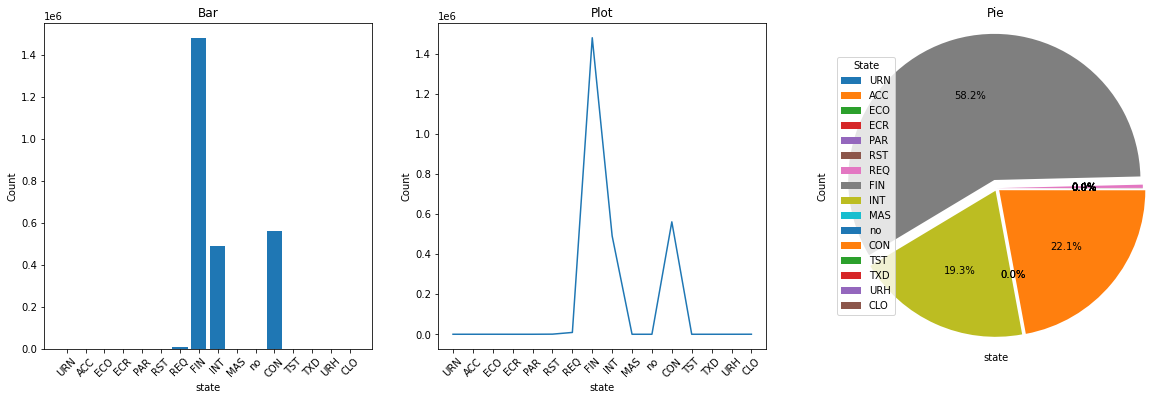

In [21]:
fig = plt.figure(figsize=(20,6))

ax1 = fig.add_subplot(131)
ax1.bar(data['state'], data['count'])
ax1.set_ylabel('Count')
ax1.set_xlabel('state')
plt.xticks(rotation=45)
ax1.grid(False)
plt.title("Bar")

ax2 = fig.add_subplot(132)
ax2.plot(data['state'], data['count'])
ax2.set_ylabel('Count')
ax2.set_xlabel('state')
plt.xticks(rotation=45)
plt.title("Plot")

ax3 = fig.add_subplot(133)
ax3.pie(data['count'], explode=data['count']/(data['count'].sum()*10), autopct="%1.1f%%")
ax3.set_ylabel('Count')
ax3.set_xlabel('state')
ax3.legend(title="State", labels=data['state'], loc='center left')
ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Pie")

plt.show()

In [22]:
#Splitting by attacks and normal the state column
data = df.groupBy('state').agg(F.count(F.when(F.col('Label') == 1, 1)).alias('Attack'),
                       F.count(F.when(F.col('Label') == 0, 1)).alias('Normal')).toPandas()
data

,state,Attack,Normal
0,URN,0,7
1,ACC,2,41
2,ECO,0,96
3,ECR,0,8
4,PAR,0,26
5,RST,13,515
6,REQ,1229,7814
7,FIN,57923,1420766
8,INT,260620,229849
9,MAS,0,7


In [23]:
data['ratio'] = data['Attack'] / data['Normal']

In [24]:
data

,state,Attack,Normal,ratio
0,URN,0,7,0.000000
1,ACC,2,41,0.048780
2,ECO,0,96,0.000000
3,ECR,0,8,0.000000
4,PAR,0,26,0.000000
5,RST,13,515,0.025243
6,REQ,1229,7814,0.157282
7,FIN,57923,1420766,0.040769
8,INT,260620,229849,1.133875
9,MAS,0,7,0.000000


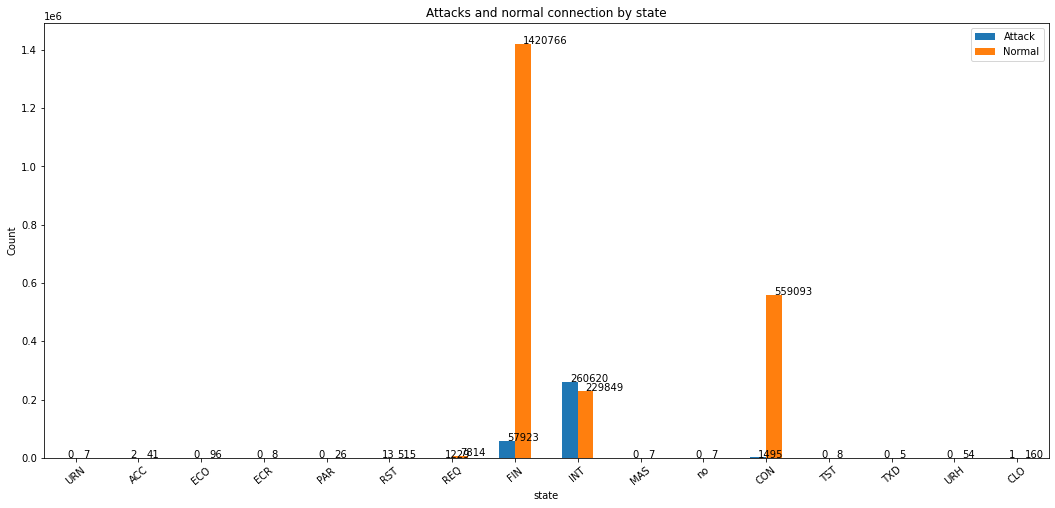

In [25]:
fig = plt.figure(figsize=(18,8))
ax = fig.subplots()
ax.set_ylabel('Count')
data.plot.bar(x = 'state', y = ['Attack', 'Normal'], rot = 40, ax = ax)
plt.title("Attacks and normal connection by state")
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()))

In [26]:
#Exploring attack_cat category
df.groupBy("attack_cat").count().toPandas()

,attack_cat,count
0,Worms,174
1,Analysis,2677
2,Shellcode,1288
3,DoS,16353
4,Reconnaissance,12228
5,Backdoor,1795
6,Fuzzers,19195
7,Exploits,44525
8,Generic,215481
9,Shellcode,223


In [27]:
#checking the label of rows having null value on the column attack_cat
df.select("attack_cat", "Label").filter(df.attack_cat.isNull()).groupBy('Label').count().show()

+-----+-------+
|Label|  count|
+-----+-------+
|    0|2218456|
+-----+-------+



In [28]:
data = df.groupBy("attack_cat").count().fillna('Normal').toPandas()
data
#there are duplicates and null values, 
#we need to clean the data first, we will do it in the cleanup step

,attack_cat,count
0,Worms,174
1,Analysis,2677
2,Shellcode,1288
3,DoS,16353
4,Reconnaissance,12228
5,Backdoor,1795
6,Fuzzers,19195
7,Exploits,44525
8,Generic,215481
9,Shellcode,223


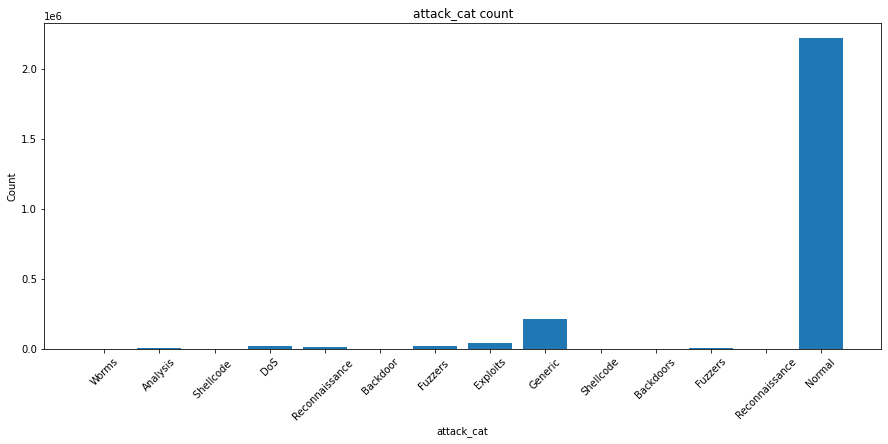

In [29]:
fig = plt.figure(figsize=(15,6))

ax1 = fig.subplots()
ax1.bar(data['attack_cat'], data['count'])
ax1.set_ylabel('Count')
ax1.set_xlabel('attack_cat')
plt.xticks(rotation=45)
ax1.grid(False)
plt.title("attack_cat count")

plt.show()

In [30]:
#Exploring the proto column
data = df.groupBy('proto').count().sort("count", ascending=False).toPandas()
data.head()

,proto,count
0,tcp,1495074
1,udp,990435
2,unas,16202
3,arp,10064
4,ospf,7798


In [31]:
print('unique protocol: ', len(data['proto'].unique()))

unique protocol:  134


/tmp/ipykernel_427246/3703005088.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(proto, fontsize= 14, fontweight='bold')


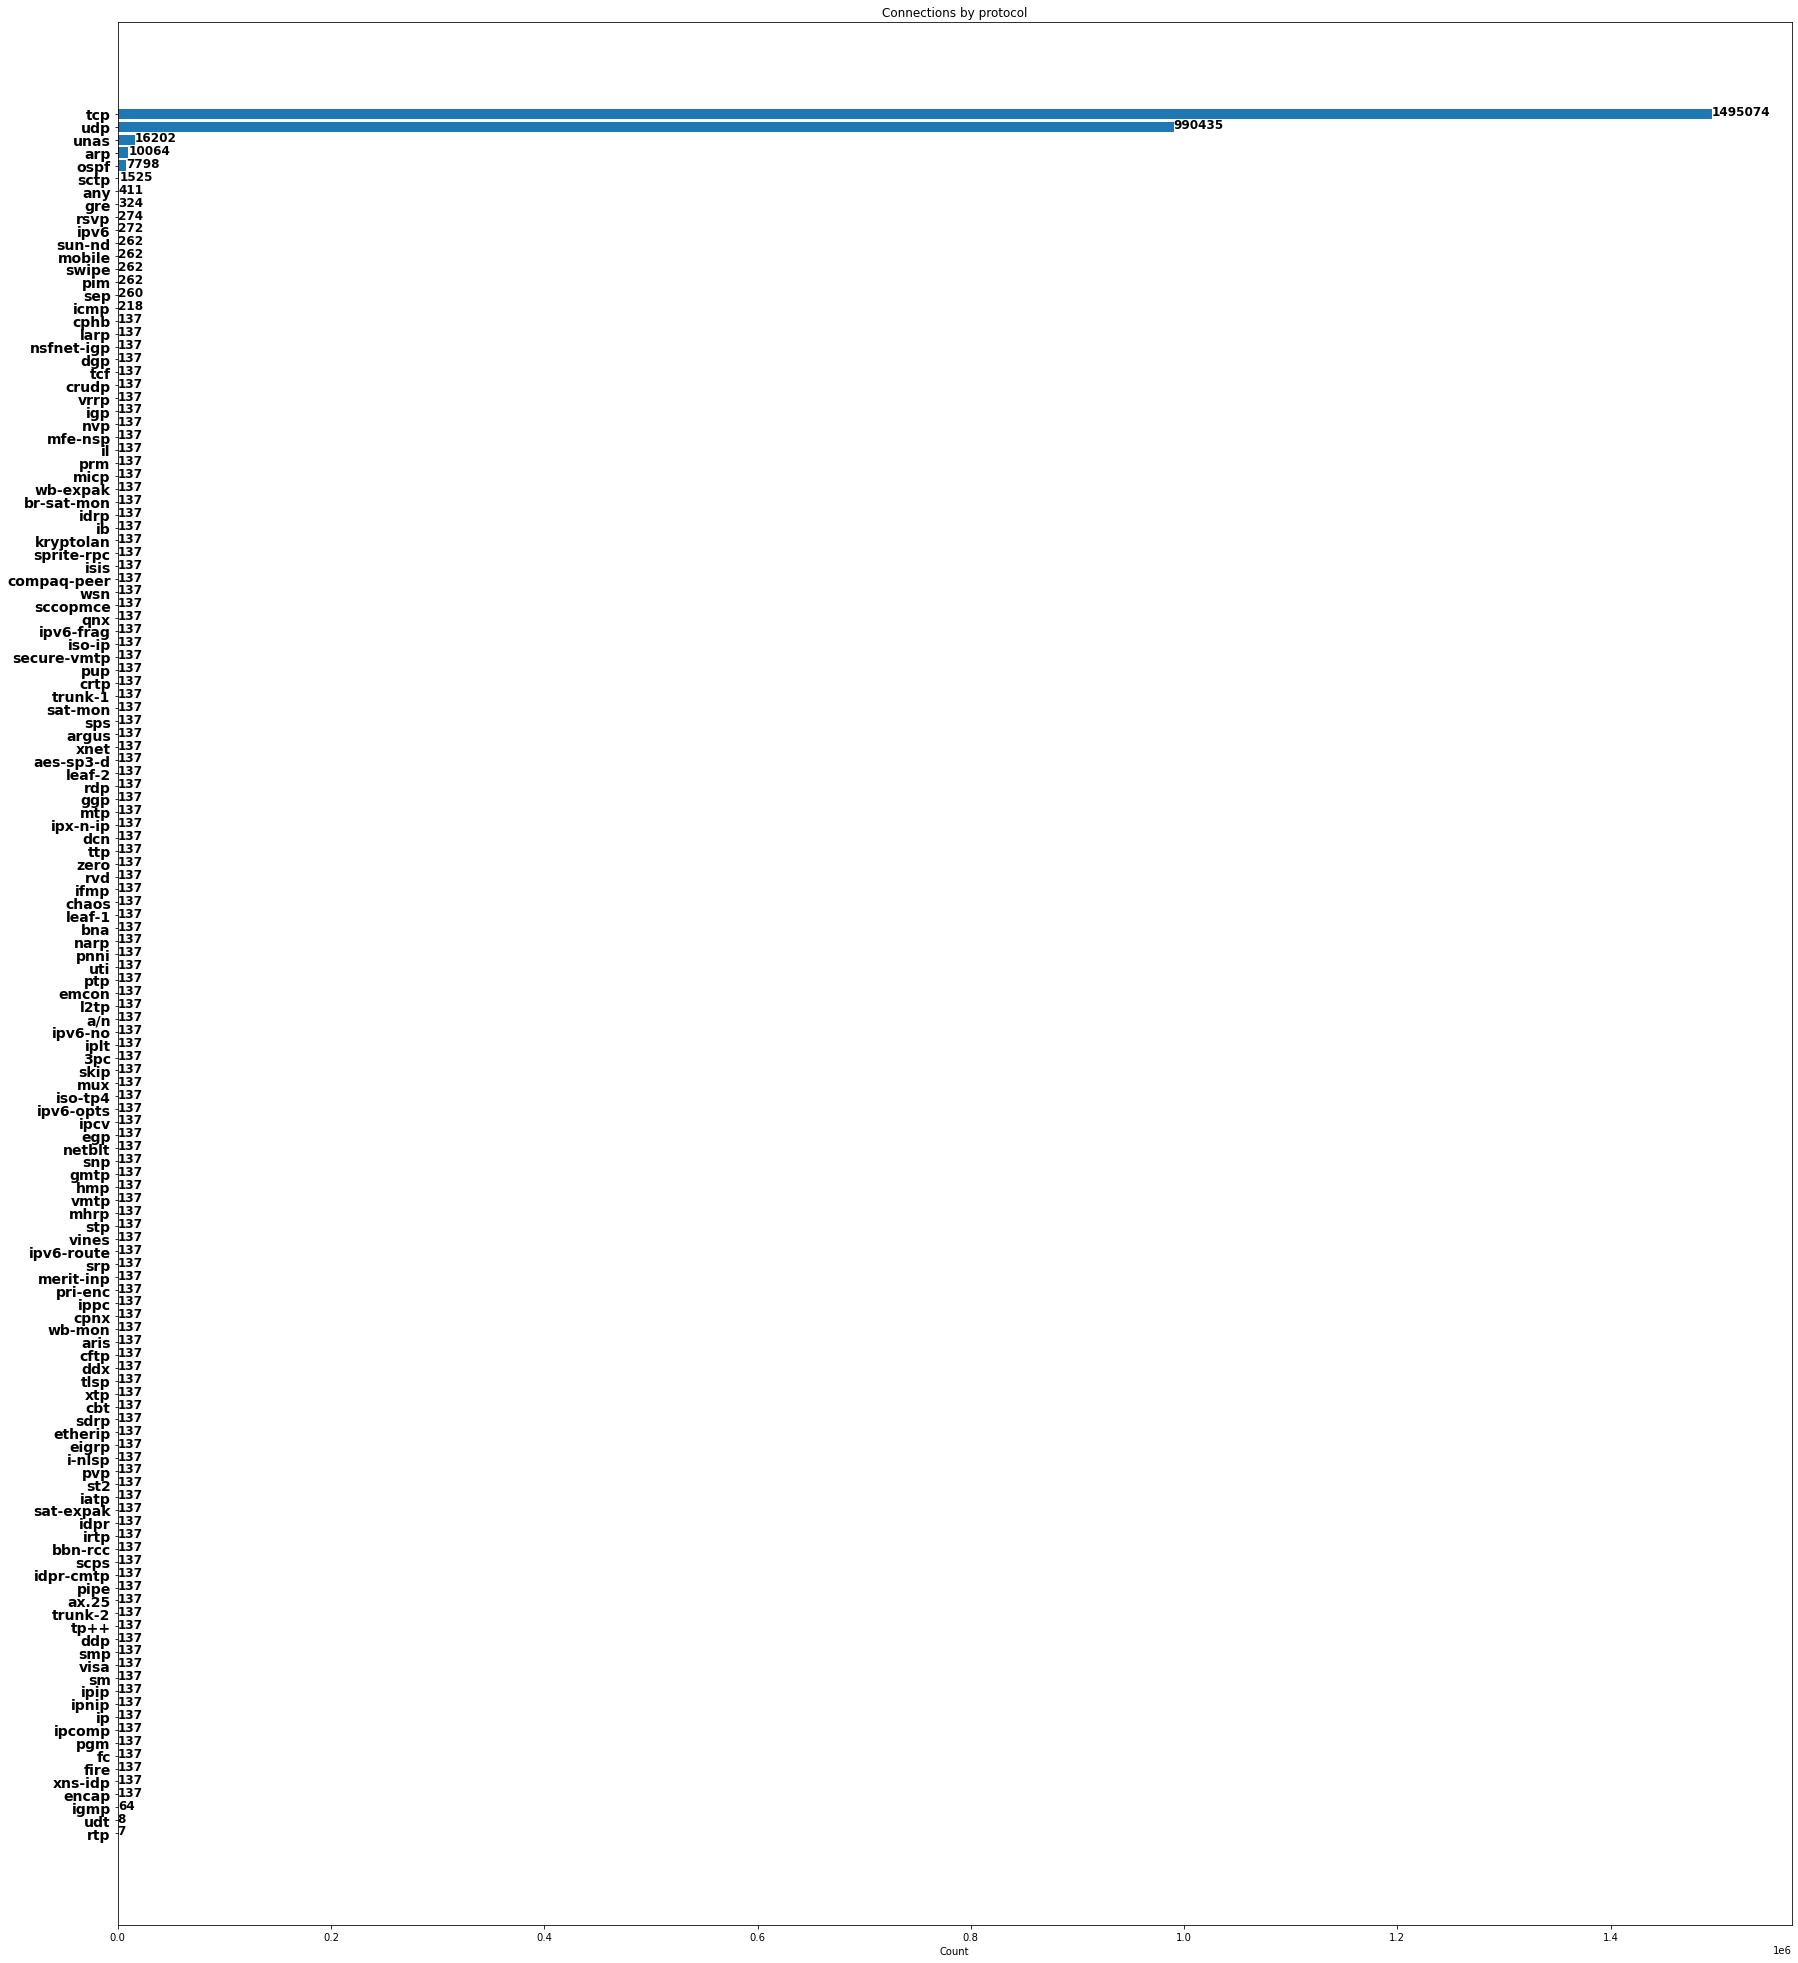

In [32]:
fig = plt.figure(figsize=(30,35))

ax = fig.subplots()

proto = data['proto']
y_pos = np.arange(len(proto))
values = data['count']

error = np.random.rand(len(proto))

ax.barh(y_pos, values, xerr=error, align='center')
ax.set_yticklabels(proto, fontsize= 14, fontweight='bold') 

ax.set_yticks(y_pos)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Count')
ax.set_title('Connections by protocol')

for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 12, fontweight ='bold',
             color ='black')
plt.show()

In [33]:
#Splitting by attacks and normal the proto column
data = df.groupBy('proto').agg(F.count(F.when(F.col('Label') == 1, 1)).alias('Attack'),
                       F.count(F.when(F.col('Label') == 0, 1)).alias('Normal')).toPandas().sort_values(by='Attack', ascending=False)
data = data.head(5)
data

,proto,Attack,Normal
128,udp,223750,766685
46,tcp,58184,1436890
130,unas,16202,0
14,ospf,3278,4520
47,sctp,1525,0


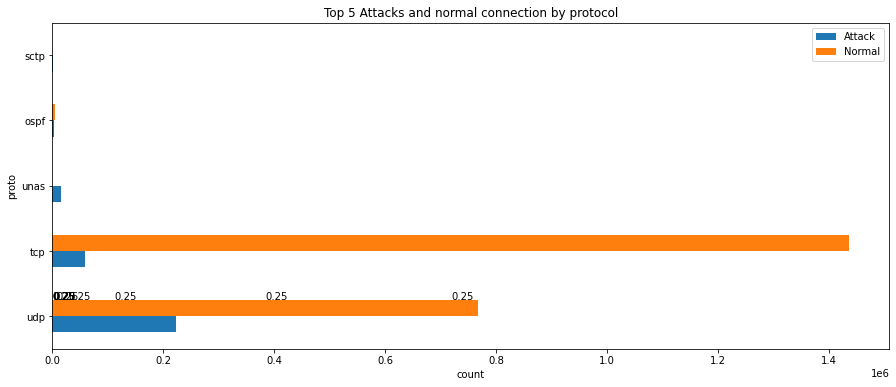

In [34]:
fig = plt.figure(figsize=(15,6))
ax = fig.subplots()
ax.set_ylabel('protocol')
ax.set_xlabel('count')
ax.set_title('Top 5 Attacks and normal connection by protocol')
data.plot.barh(x = 'proto', y = ['Attack', 'Normal'], rot = 0, ax = ax)
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()))

In [35]:
#Exploring the column service
data = df.groupBy('service').count().toPandas()
data.head(100)

,service,count
0,ftp,49090
1,ftp-data,125783
2,dns,781668
3,smtp,81645
4,http,206273
5,radius,40
6,ssl,142
7,-,1246089
8,irc,31
9,dhcp,172


In [36]:
#Let's summarize the by attacks, normal and total
data = df.groupBy('service').agg(F.count(df.service).alias("Total"),
    F.count(F.when(F.col('Label') == 1, 1)).alias('Attack'),
                       F.count(F.when(F.col('Label') == 0, 1)).alias('Normal')).toPandas().sort_values(by='Attack', ascending=False)
data

,service,Total,Attack,Normal
2,dns,781668,210631,571037
7,-,1246089,79877,1166212
4,http,206273,18847,187426
3,smtp,81645,4989,76656
0,ftp,49090,3015,46075
1,ftp-data,125783,1890,123893
11,pop3,1533,1529,4
9,dhcp,172,172,0
6,ssl,142,142,0
10,snmp,113,112,1


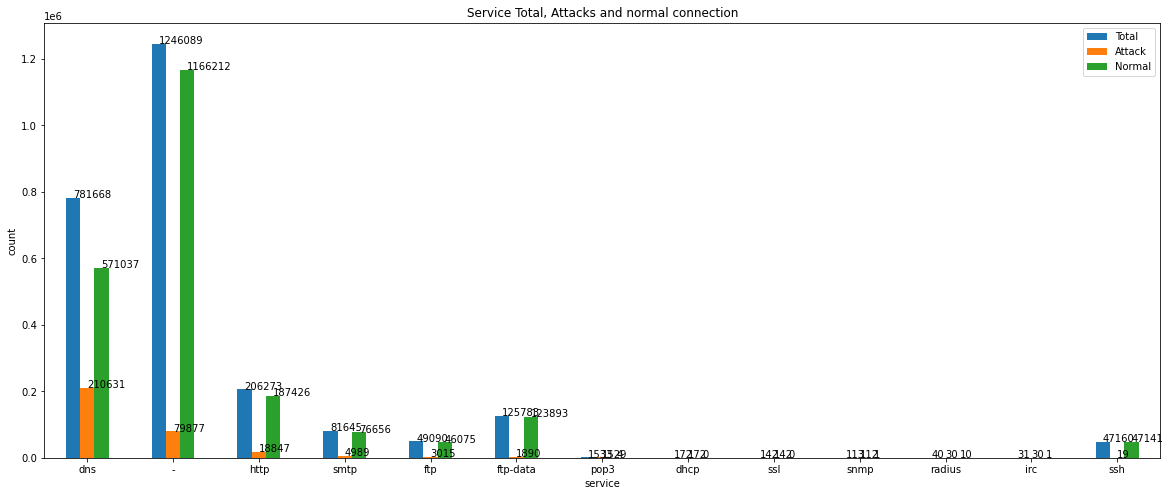

In [37]:
fig = plt.figure(figsize=(20,8))
ax = fig.subplots()
ax.set_ylabel('count')
ax.set_xlabel('service')
ax.set_title('Service Total, Attacks and normal connection')
data.plot.bar(x = 'service', y = ['Total','Attack', 'Normal'], rot = 0, ax = ax)
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()))

### Exploring numerical features

In [38]:
#the column which has more interest for that analysis are
num_cols = ['sbytes','dbytes','sttl','dttl','sloss','dloss','Sload','Dload','Spkts','Dpkts','swin','dwin','stcpb']
data_num = df.select(num_cols)

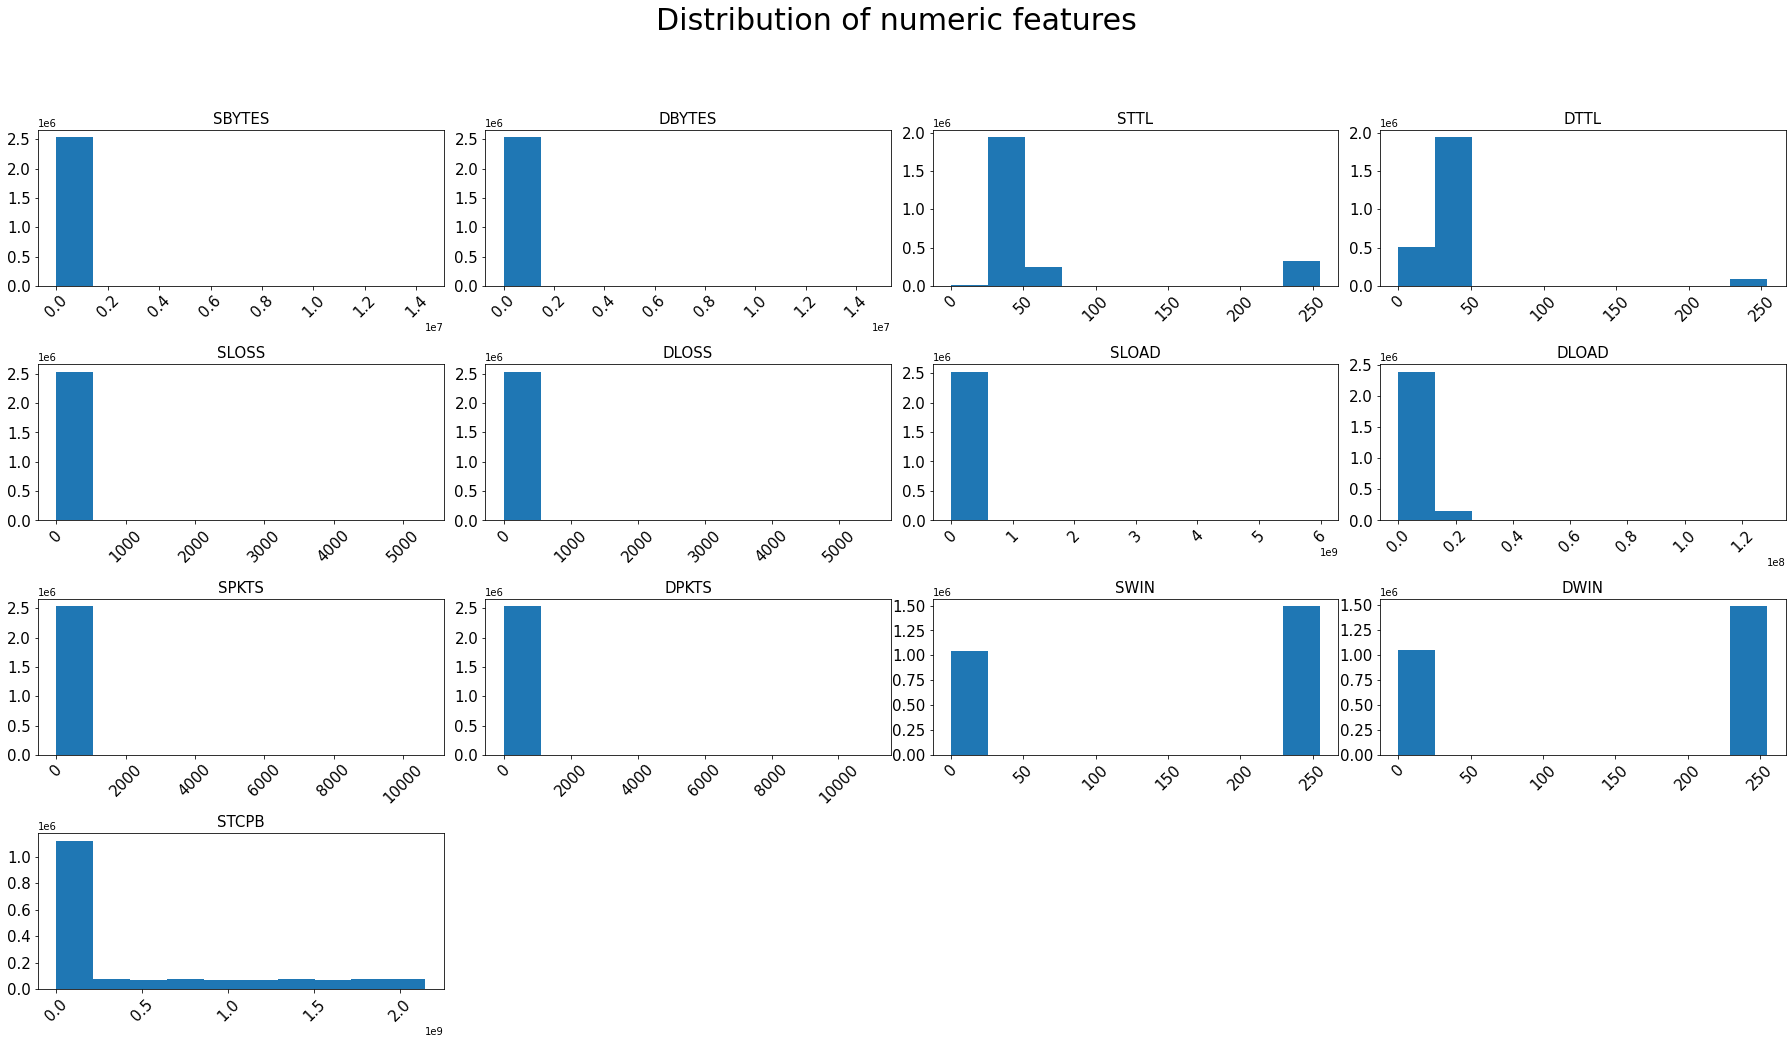

In [39]:
fig = plt.figure(figsize=(25, 15))
st = fig.suptitle("Distribution of numeric features", fontsize = 30, verticalalignment="center")

for col, num in zip(data_num.columns, range(1, len(data_num.columns)+1)):
    ax = fig.add_subplot(4,4, num)
    ax.hist(data_num.select(col).toPandas())
    plt.grid(False)
    plt.xticks(rotation=45, fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(col.upper(), fontsize=15)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.5)
plt.show()

In [40]:
num_cols2 = ['dtcpb','smeansz','dmeansz','trans_depth','res_bdy_len','Sjit','Djit',
            'Sintpkt','Dintpkt','tcprtt','synack','ackdat']
data_num = df.select(num_cols2)

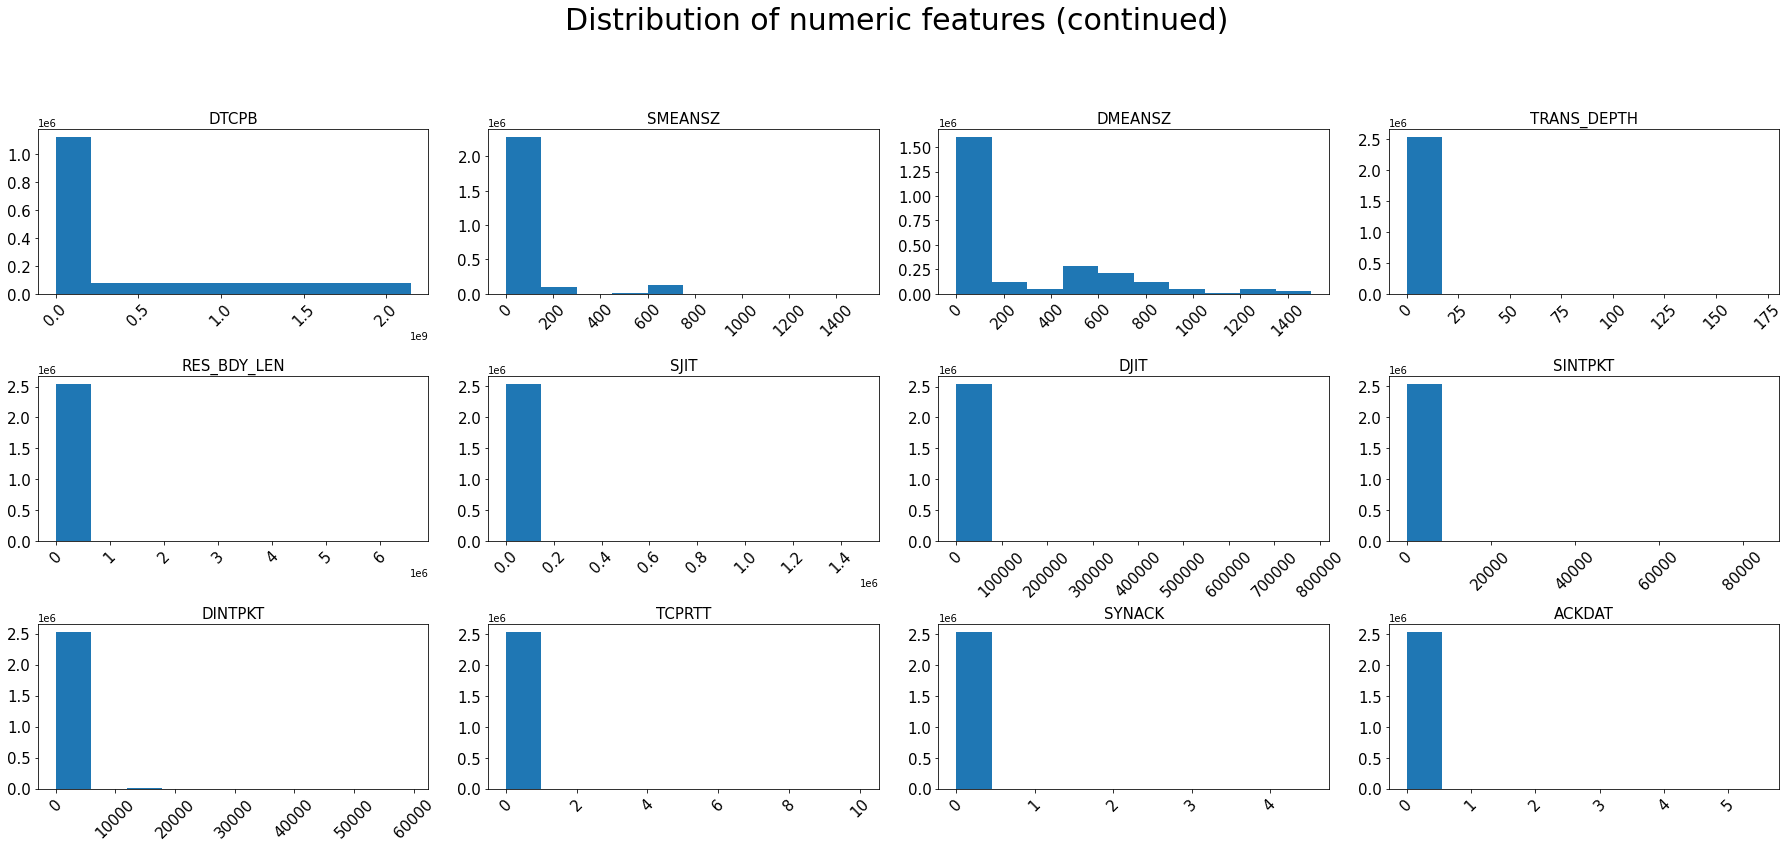

In [41]:
fig = plt.figure(figsize=(25, 15))
st = fig.suptitle("Distribution of numeric features (continued)", fontsize = 30, verticalalignment="center")

for col, num in zip(data_num.columns, range(1, len(data_num.columns)+1)):
    ax = fig.add_subplot(4,4, num)
    ax.hist(data_num.select(col).toPandas())
    plt.grid(False)
    plt.xticks(rotation=45, fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(col.upper(), fontsize=15)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.5)
plt.show()

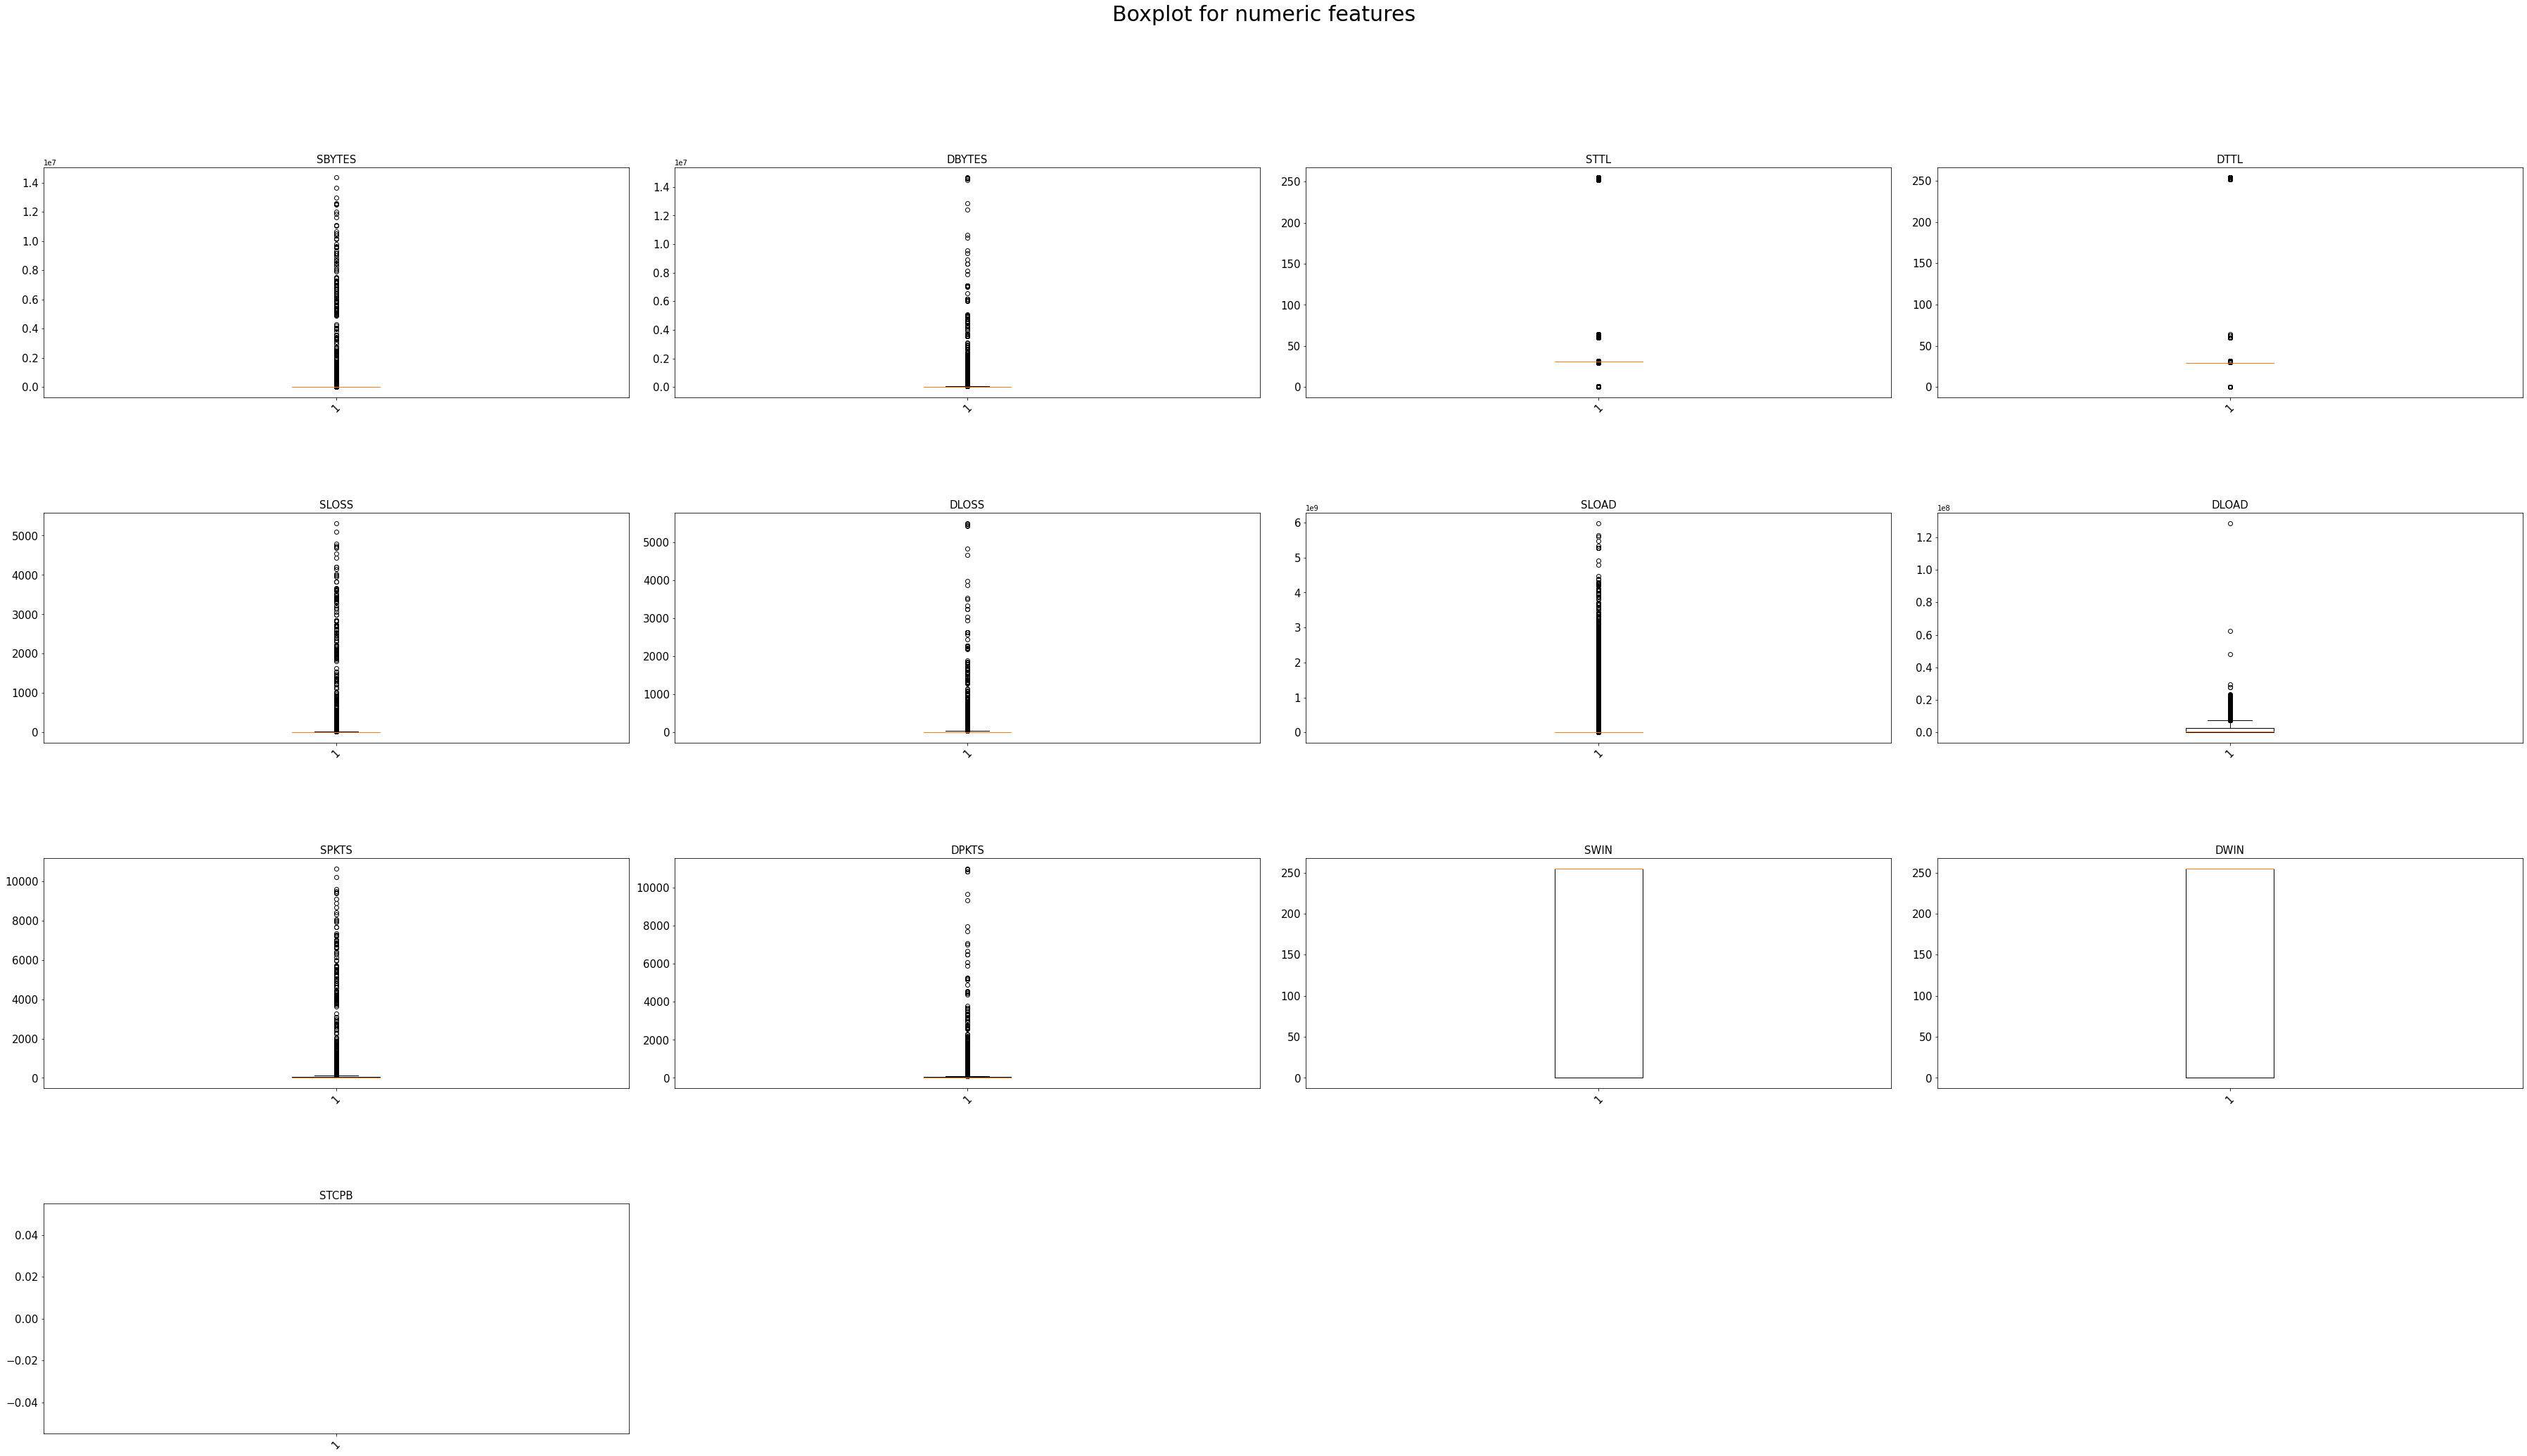

In [42]:
data_num = df.select(num_cols)
fig = plt.figure(figsize=(50, 30))
st = fig.suptitle("Boxplot for numeric features", fontsize = 30, verticalalignment="center")

for col, num in zip(data_num.columns, range(1, len(data_num.columns)+1)):
    ax = fig.add_subplot(4,4, num)
    ax.boxplot(data_num.select(col).toPandas())
    plt.grid(False)
    plt.xticks(rotation=45, fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(col.upper(), fontsize=15)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.5)
plt.show()

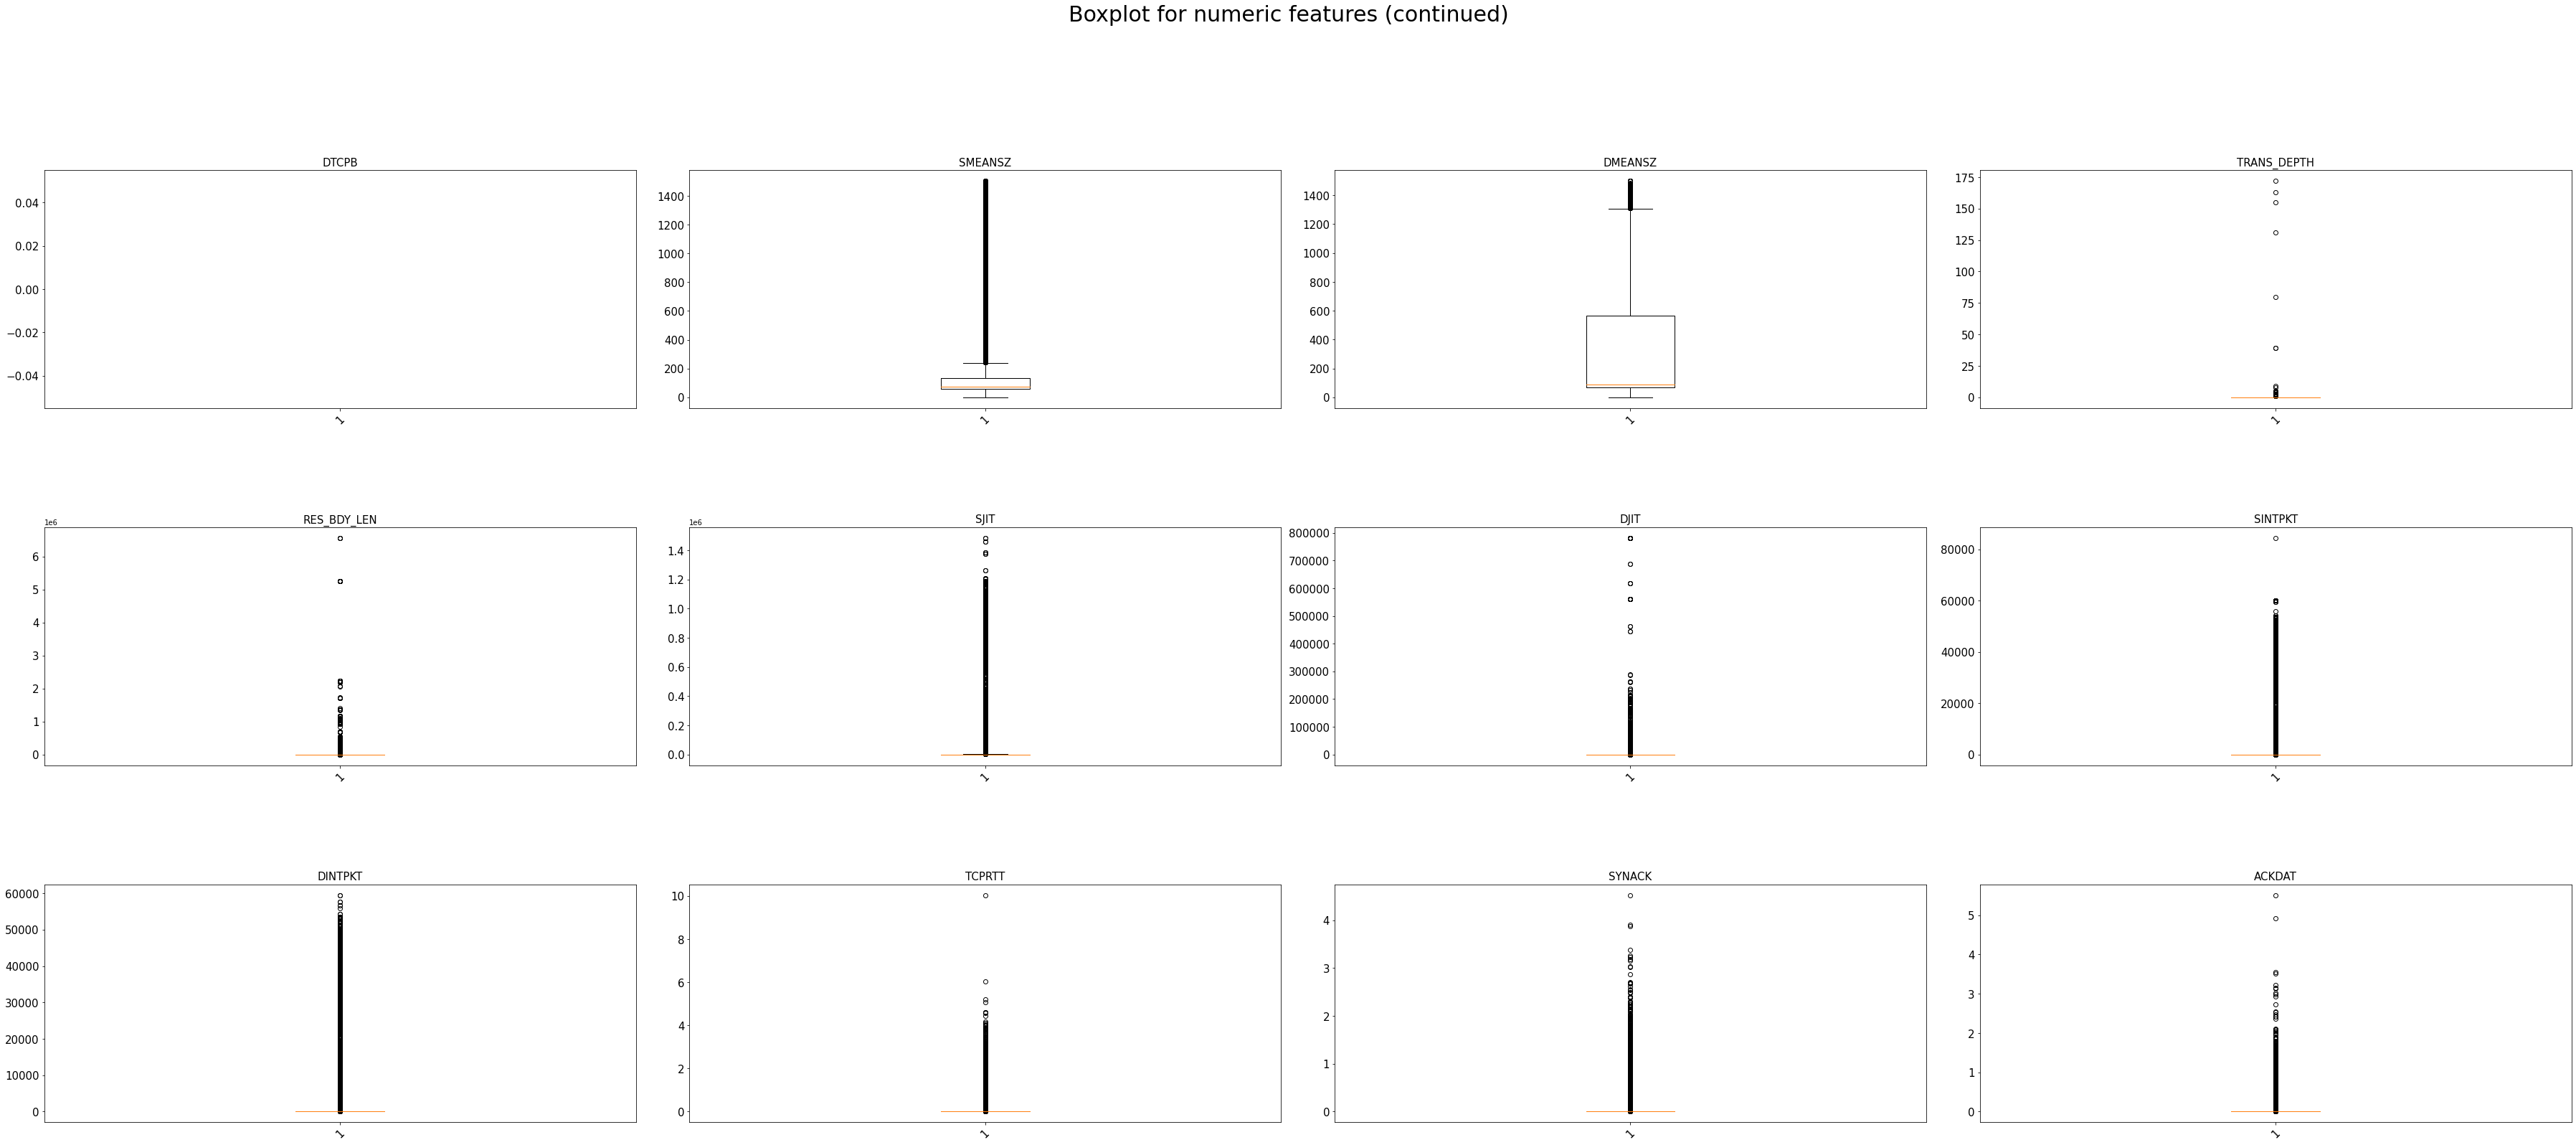

In [43]:
data_num = df.select(num_cols2)
fig = plt.figure(figsize=(50, 30))
st = fig.suptitle("Boxplot for numeric features (continued)", fontsize = 30, verticalalignment="center")

for col, num in zip(data_num.columns, range(1, len(data_num.columns)+1)):
    ax = fig.add_subplot(4,4, num)
    ax.boxplot(data_num.select(col).toPandas())
    plt.grid(False)
    plt.xticks(rotation=45, fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(col.upper(), fontsize=15)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.5)
plt.show()

### Kernel Density Estimate

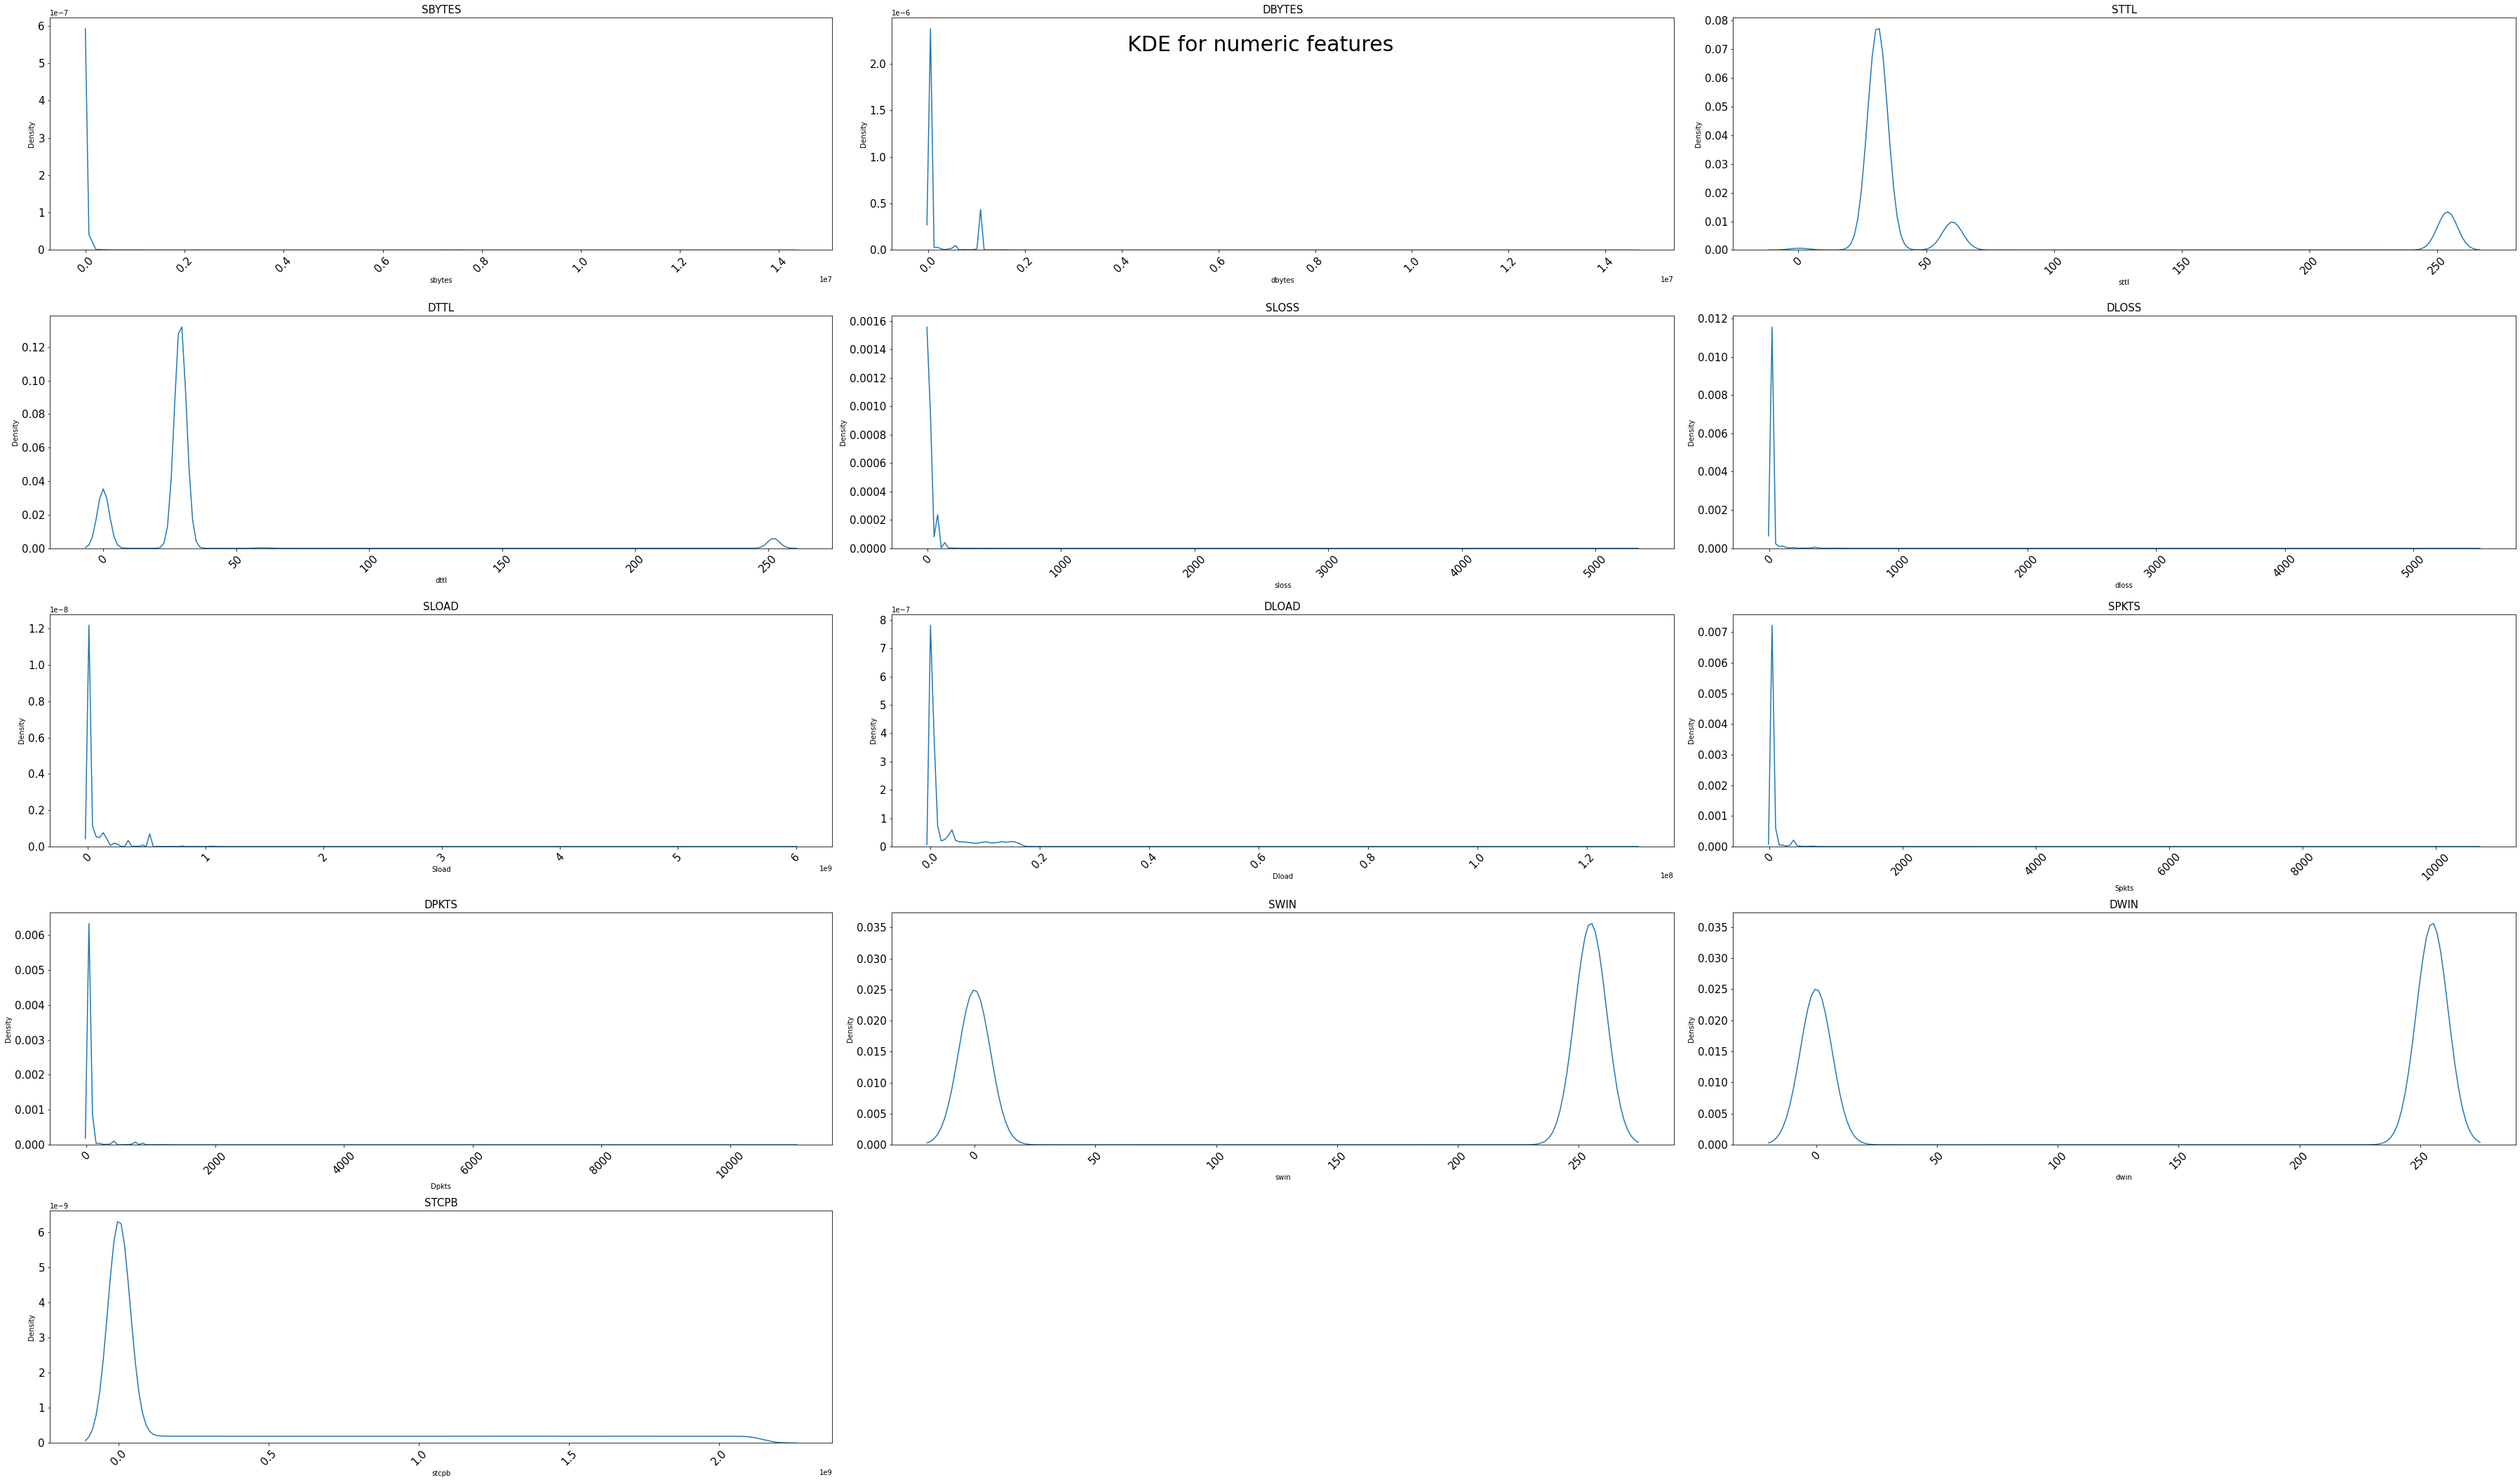

In [44]:
data_num = df.select(num_cols)
fig = plt.figure(figsize=(50, 30))
st = fig.suptitle("KDE for numeric features", fontsize = 30, verticalalignment="center")

for col, num in zip(data_num.columns, range(1, len(data_num.columns)+1)):
    ax = fig.add_subplot(5,3, num)
    #ax.boxplot(data_num.select(col).toPandas())
    sns.kdeplot(df.select(col).toPandas()[col])
    plt.grid(False)
    plt.xticks(rotation=45, fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(col.upper(), fontsize=15)
plt.tight_layout()
st.set_y(0.95)
#fig.subplots_adjust(top=0.85, hspace=0.5)
plt.show()

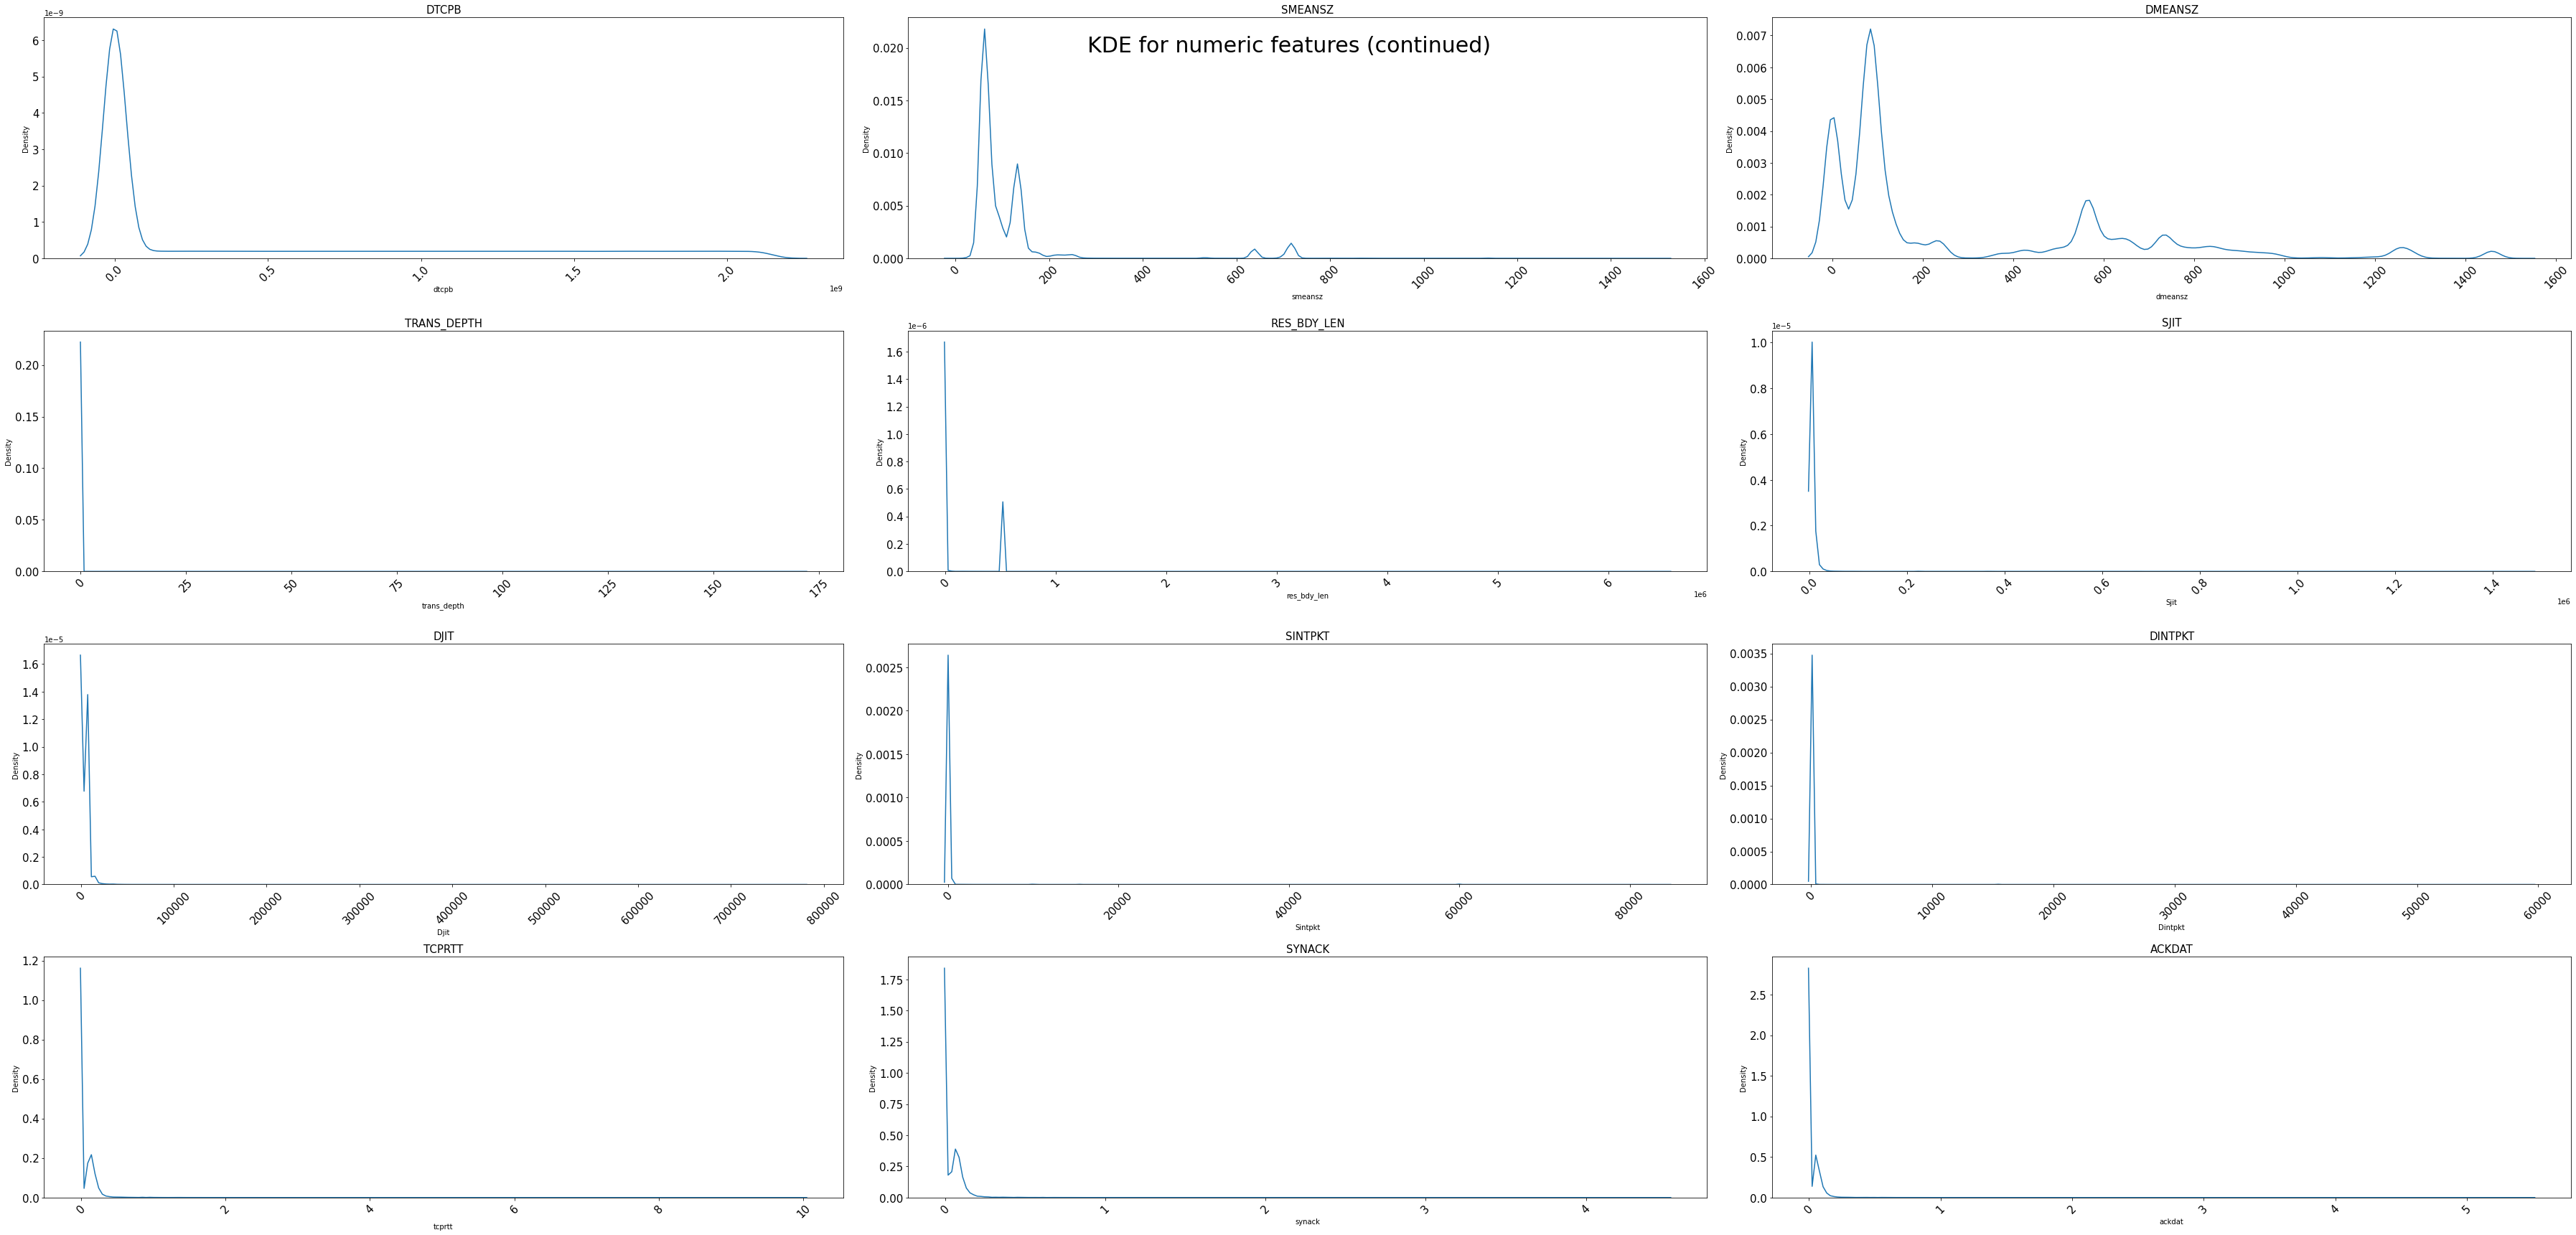

In [45]:
data_num = df.select(num_cols2)
fig = plt.figure(figsize=(50, 30))
st = fig.suptitle("KDE for numeric features (continued)", fontsize = 30, verticalalignment="center")

for col, num in zip(data_num.columns, range(1, len(data_num.columns)+1)):
    ax = fig.add_subplot(5,3, num)
    #ax.boxplot(data_num.select(col).toPandas())
    sns.kdeplot(df.select(col).toPandas()[col])
    plt.grid(False)
    plt.xticks(rotation=45, fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(col.upper(), fontsize=15)
plt.tight_layout()
st.set_y(0.95)
#fig.subplots_adjust(top=0.85, hspace=0.5)
plt.show()

we can observe that all features have a binomial distribution or are skewed, none of them have a normal distribution

### Summary statistics

In [46]:
num_cols_analysis = ['sbytes','dbytes','sttl','dttl','sloss','dloss','Sload','Dload','Spkts','Dpkts','swin','dwin',
                     'stcpb','dtcpb','smeansz','dmeansz','trans_depth','res_bdy_len',
                     'Sjit','Djit','Sintpkt','Dintpkt','tcprtt','synack','ackdat']

In [47]:
data  = df.select(num_cols_analysis).summary().toPandas()
data.transpose()

,0,1,2,3,4,5,6,7
summary,count,mean,stddev,min,25%,50%,75%,max
sbytes,2539739,4340.072263330996,56409.39812286232,0,200,1470,3182,14355774
dbytes,2539739,36432.01132478574,161105.30400824756,0,178,1820,14908,14657531
sttl,2539739,62.78149802007214,74.62669956848524,0,31,31,31,255
dttl,2539739,30.770440978384,42.851922189518724,0,29,29,29,254
sloss,2539739,5.164547223159545,22.51836838779722,0,0,3,7,5319
dloss,2539739,16.331423819534212,56.597890353205116,0,0,4,14,5507
Sload,2539739,3.694927929101865E7,1.1860413778897691E8,0.0,135354.89,589303.75,2036831.1,5.9880003E9
Dload,2539739,2451158.4380010013,4225032.897361651,0.0,11935.401,589398.06,2926335.2,1.28761904E8
Spkts,2539739,33.2925678583508,76.28775585678378,0,2,12,44,10646


# Data cleanup and transformation

In [48]:
#checking clolumns with null values
df_null = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()
df_null.index = ['count']
df_null = df_null[[column for column in df_null.columns if df_null.loc['count'][column] > 0]]
df_null

,stcpb,dtcpb,attack_cat
count,745798,746426,2218456


In [49]:
#the result is showing that only the columns stcpb and dtcpb and attack_cat have null values
#the result is showing 745,798 null value rows, about a third of the total number of rows. 
#Since the field represents a sequence number for a tcp packet on witch we cant perform computation,
#we will fill all those null values with the mean 
df.select('stcpb').groupBy('stcpb').count().sort("count", ascending=False).show(5)
df.select('dtcpb').groupBy('dtcpb').count().sort("count", ascending=False).show(5)

df = df.fillna(0, subset=['stcpb'])
df.select('stcpb').filter(df.stcpb.isNull()).groupBy('stcpb').count().show()

df = df.fillna(0, subset=['dtcpb'])
df.select('dtcpb').filter(df.dtcpb.isNull()).groupBy('dtcpb').count().show()

+----------+-------+
|     stcpb|  count|
+----------+-------+
|         0|1047558|
|      null| 745798|
|1869730950|     44|
| 542769827|     37|
|1355152323|     36|
+----------+-------+
only showing top 5 rows



+---------+-------+
|    dtcpb|  count|
+---------+-------+
|        0|1047883|
|     null| 746426|
|439364479|     44|
|555170381|     37|
| 34807851|     36|
+---------+-------+
only showing top 5 rows

+-----+-----+
|stcpb|count|
+-----+-----+
+-----+-----+

+-----+-----+
|dtcpb|count|
+-----+-----+
+-----+-----+



## Handling Categorical data

In [50]:
df.select('proto', 'state', 'service', 'attack_cat', 'srcip', 'dstip').show(10)

+-----+-----+--------+----------+----------+-------------+
|proto|state| service|attack_cat|     srcip|        dstip|
+-----+-----+--------+----------+----------+-------------+
|  tcp|  FIN|       -|      null|59.166.0.3|149.171.126.8|
|  tcp|  FIN|       -|      null|59.166.0.0|149.171.126.6|
|  tcp|  FIN|       -|      null|59.166.0.5|149.171.126.2|
|  tcp|  FIN|       -|      null|59.166.0.9|149.171.126.0|
|  tcp|  FIN|       -|      null|59.166.0.8|149.171.126.9|
|  tcp|  FIN|       -|      null|59.166.0.3|149.171.126.3|
|  udp|  CON|     dns|      null|59.166.0.7|149.171.126.0|
|  tcp|  FIN|ftp-data|      null|59.166.0.3|149.171.126.9|
|  udp|  CON|     dns|      null|59.166.0.9|149.171.126.2|
|  udp|  CON|     dns|      null|59.166.0.7|149.171.126.5|
+-----+-----+--------+----------+----------+-------------+
only showing top 10 rows



In [51]:
df.select('proto').groupBy('proto').count().sort('proto', ascending=True).show(1000)

+-----------+-------+
|      proto|  count|
+-----------+-------+
|        3pc|    137|
|        a/n|    137|
|  aes-sp3-d|    137|
|        any|    411|
|      argus|    137|
|       aris|    137|
|        arp|  10064|
|      ax.25|    137|
|    bbn-rcc|    137|
|        bna|    137|
| br-sat-mon|    137|
|        cbt|    137|
|       cftp|    137|
|      chaos|    137|
|compaq-peer|    137|
|       cphb|    137|
|       cpnx|    137|
|       crtp|    137|
|      crudp|    137|
|        dcn|    137|
|        ddp|    137|
|        ddx|    137|
|        dgp|    137|
|        egp|    137|
|      eigrp|    137|
|      emcon|    137|
|      encap|    137|
|    etherip|    137|
|         fc|    137|
|       fire|    137|
|        ggp|    137|
|       gmtp|    137|
|        gre|    324|
|        hmp|    137|
|     i-nlsp|    137|
|       iatp|    137|
|         ib|    137|
|       icmp|    218|
|       idpr|    137|
|  idpr-cmtp|    137|
|       idrp|    137|
|       ifmp|    137|
|       ig

In [52]:
df.select('state').groupBy('state').count().sort('state', ascending=True).show(100)

+-----+-------+
|state|  count|
+-----+-------+
|  ACC|     43|
|  CLO|    161|
|  CON| 560588|
|  ECO|     96|
|  ECR|      8|
|  FIN|1478689|
|  INT| 490469|
|  MAS|      7|
|  PAR|     26|
|  REQ|   9043|
|  RST|    528|
|  TST|      8|
|  TXD|      5|
|  URH|     54|
|  URN|      7|
|   no|      7|
+-----+-------+



In [53]:
df.select('service').groupBy('service').count().sort('service', ascending=True).show(100)
#The output is showing that some services has the value "-",

+--------+-------+
| service|  count|
+--------+-------+
|       -|1246089|
|    dhcp|    172|
|     dns| 781668|
|     ftp|  49090|
|ftp-data| 125783|
|    http| 206273|
|     irc|     31|
|    pop3|   1533|
|  radius|     40|
|    smtp|  81645|
|    snmp|    113|
|     ssh|  47160|
|     ssl|    142|
+--------+-------+



In [54]:
#we will replace it by the mode of the column, which is dns for the case
df = df.withColumn("service", F.when(df.service == '-', 'dns').otherwise(df.service))
df.select('service').groupBy('service').count().sort('service', ascending=True).show(100)

+--------+-------+
| service|  count|
+--------+-------+
|    dhcp|    172|
|     dns|2027757|
|     ftp|  49090|
|ftp-data| 125783|
|    http| 206273|
|     irc|     31|
|    pop3|   1533|
|  radius|     40|
|    smtp|  81645|
|    snmp|    113|
|     ssh|  47160|
|     ssl|    142|
+--------+-------+



In [55]:
indexer = StringIndexer(inputCol='proto', outputCol='proto_idx')
df = indexer.fit(df).transform(df)

indexer = StringIndexer(inputCol='state', outputCol='state_idx')
df = indexer.fit(df).transform(df)

indexer = StringIndexer(inputCol='service', outputCol='service_idx')
df = indexer.fit(df).transform(df)

indexer = StringIndexer(inputCol='srcip', outputCol='srcip_idx')
df = indexer.fit(df).transform(df)

indexer = StringIndexer(inputCol='dstip', outputCol='dstip_idx')
df = indexer.fit(df).transform(df)

encoder = OneHotEncoder(inputCols=['proto_idx', 'state_idx', 'service_idx', 'srcip_idx', 'dstip_idx'],
                        outputCols=['proto_vec', 'state_vec', 'service_vec', 'srcip_vec', 'dstip_vec'])
model = encoder.fit(df)
df = model.transform(df)
df.show(10)

+----------+-----+-------------+------+-----+-----+--------+------+------+----+----+-----+-----+--------+---------+---------+-----+-----+----+----+---------+----------+-------+-------+-----------+-----------+---------+---------+----------+----------+---------+--------+-------+-------+-------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+---------+---------+-----------+---------+---------+---------------+--------------+--------------+--------------+--------------+
|     srcip|sport|        dstip|dsport|proto|state|     dur|sbytes|dbytes|sttl|dttl|sloss|dloss| service|    Sload|    Dload|Spkts|Dpkts|swin|dwin|    stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|     Sjit|     Djit|     Stime|     Ltime|  Sintpkt| Dintpkt| tcprtt| synack| ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|c

In [56]:
#delete the original columns
df = df.drop('proto_idx', 'state_idx', 'service_idx', 'srcip_idx', 'dstip_idx')
df = df.drop('proto', 'state', 'service', 'srcip', 'dstip')
df.show(10)

+-----+------+--------+------+------+----+----+-----+-----+---------+---------+-----+-----+----+----+---------+----------+-------+-------+-----------+-----------+---------+---------+----------+----------+---------+--------+-------+-------+-------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+---------------+--------------+--------------+--------------+--------------+
|sport|dsport|     dur|sbytes|dbytes|sttl|dttl|sloss|dloss|    Sload|    Dload|Spkts|Dpkts|swin|dwin|    stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|     Sjit|     Djit|     Stime|     Ltime|  Sintpkt| Dintpkt| tcprtt| synack| ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|      proto_vec|     state_vec|   service_vec|     srcip_vec|     d

In [57]:
#replace null value for attack_cat where Label is 0 by 'Normal'
df.where((df['Label'] == 0)).select('attack_cat').groupBy('attack_cat').count().show()

+----------+-------+
|attack_cat|  count|
+----------+-------+
|      null|2218456|
+----------+-------+



In [58]:
#there are spaces on the column 'attack_cat'
df = df.withColumn("attack_cat", F.trim(df.attack_cat))
df.groupBy('attack_cat').count().show()
#df.select(F.trim('attack_cat').alias('attack_cat2')).groupBy('attack_cat2').count().show() #= df.select()

+--------------+-------+
|    attack_cat|  count|
+--------------+-------+
|         Worms|    174|
|     Shellcode|   1511|
|       Fuzzers|  24246|
|      Analysis|   2677|
|           DoS|  16353|
|Reconnaissance|  13987|
|      Backdoor|   1795|
|      Exploits|  44525|
|       Generic| 215481|
|     Backdoors|    534|
|          null|2218456|
+--------------+-------+



In [59]:
#change Backdoor to Backdoors
df = df.withColumn("attack_cat", F.when(df.attack_cat == 'Backdoor', 'Backdoors').otherwise(df.attack_cat))
df.groupBy('attack_cat').count().show()

+--------------+-------+
|    attack_cat|  count|
+--------------+-------+
|         Worms|    174|
|     Shellcode|   1511|
|     Backdoors|   2329|
|       Fuzzers|  24246|
|      Analysis|   2677|
|           DoS|  16353|
|Reconnaissance|  13987|
|      Exploits|  44525|
|       Generic| 215481|
|          null|2218456|
+--------------+-------+



In [60]:
df.filter(df.attack_cat.isNull()).show()

+-----+------+--------+------+------+----+----+-----+-----+---------+---------+-----+-----+----+----+----------+----------+-------+-------+-----------+-----------+---------+---------+----------+----------+---------+---------+-------+-------+-------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+---------------+--------------+--------------+--------------+--------------+
|sport|dsport|     dur|sbytes|dbytes|sttl|dttl|sloss|dloss|    Sload|    Dload|Spkts|Dpkts|swin|dwin|     stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|     Sjit|     Djit|     Stime|     Ltime|  Sintpkt|  Dintpkt| tcprtt| synack| ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|      proto_vec|     state_vec|   service_vec|     srcip_vec|  

In [61]:
#change null value to Normal
df = df.fillna('Normal', subset=['attack_cat'])
df.groupBy('attack_cat').count().show()

+--------------+-------+
|    attack_cat|  count|
+--------------+-------+
|         Worms|    174|
|     Shellcode|   1511|
|     Backdoors|   2329|
|       Fuzzers|  24246|
|      Analysis|   2677|
|           DoS|  16353|
|Reconnaissance|  13987|
|      Exploits|  44525|
|        Normal|2218456|
|       Generic| 215481|
+--------------+-------+



In [62]:
#Convert it to numerical value since we will use this column as label for multiclass classification
indexer = StringIndexer(inputCol='attack_cat', outputCol='attack_cat_idx')
df = indexer.fit(df).transform(df).drop('attack_cat')
df.select('attack_cat_idx').groupBy("attack_cat_idx").count().show(10)

+--------------+-------+
|attack_cat_idx|  count|
+--------------+-------+
|           8.0|   1511|
|           0.0|2218456|
|           7.0|   2329|
|           1.0| 215481|
|           4.0|  16353|
|           3.0|  24246|
|           2.0|  44525|
|           6.0|   2677|
|           5.0|  13987|
|           9.0|    174|
+--------------+-------+



## Handling Timestamp columns

In [63]:
#convert the timestamp to datetime for the column Stime and Ltime
df = df.withColumn("Stime", F.from_unixtime(df.Stime))
df = df.withColumn("Ltime", F.from_unixtime(df.Ltime))
df.select('Stime','Ltime').show(5)
df.select('Stime','Ltime').printSchema()

+-------------------+-------------------+
|              Stime|              Ltime|
+-------------------+-------------------+
|2015-01-22 23:52:54|2015-01-22 23:52:55|
|2015-01-22 23:52:55|2015-01-22 23:52:55|
|2015-01-22 23:52:55|2015-01-22 23:52:55|
|2015-01-22 23:52:52|2015-01-22 23:52:55|
|2015-01-22 23:52:53|2015-01-22 23:52:55|
+-------------------+-------------------+
only showing top 5 rows

root
 |-- Stime: string (nullable = true)
 |-- Ltime: string (nullable = true)



In [64]:
#split the Stime column into year, month and day
df = df.withColumn("Stime_year", F.split(F.split(df.Stime, ' ')[0], '-')[0])
df = df.withColumn("Stime_month", F.split(F.split(df.Stime, ' ')[0], '-')[1])
df = df.withColumn("Stime_day", F.split(F.split(df.Stime, ' ')[0], '-')[2])
df.select('Stime_year','Stime_month', 'Stime_day').show()

+----------+-----------+---------+
|Stime_year|Stime_month|Stime_day|
+----------+-----------+---------+
|      2015|         01|       22|
|      2015|         01|       22|
|      2015|         01|       22|
|      2015|         01|       22|
|      2015|         01|       22|
|      2015|         01|       22|
|      2015|         01|       22|
|      2015|         01|       22|
|      2015|         01|       22|
|      2015|         01|       22|
|      2015|         01|       22|
|      2015|         01|       22|
|      2015|         01|       22|
|      2015|         01|       22|
|      2015|         01|       22|
|      2015|         01|       22|
|      2015|         01|       22|
|      2015|         01|       22|
|      2015|         01|       22|
|      2015|         01|       22|
+----------+-----------+---------+
only showing top 20 rows



In [65]:
#split the Ltime column into year, month and day
df = df.withColumn("Ltime_year", F.split(F.split(df.Ltime, ' ')[0], '-')[0])
df = df.withColumn("Ltime_month", F.split(F.split(df.Ltime, ' ')[0], '-')[1])
df = df.withColumn("Ltime_day", F.split(F.split(df.Ltime, ' ')[0], '-')[2])
df.select('Ltime_year','Ltime_month', 'Ltime_day').show(5)
#delete the original column Stime and Ltime
df = df.drop("Stime", "Ltime")

+----------+-----------+---------+
|Ltime_year|Ltime_month|Ltime_day|
+----------+-----------+---------+
|      2015|         01|       22|
|      2015|         01|       22|
|      2015|         01|       22|
|      2015|         01|       22|
|      2015|         01|       22|
+----------+-----------+---------+
only showing top 5 rows



In [66]:
#change the type of newly created column to integer
df = df.withColumn("Stime_year",df.Stime_year.cast('integer'))
df = df.withColumn("Stime_month",df.Stime_month.cast('integer'))
df = df.withColumn("Stime_day",df.Stime_day.cast('integer'))
df.select('Stime_year','Stime_month', 'Stime_day').show(5)
df.select('Stime_year','Stime_month', 'Stime_day').printSchema()

+----------+-----------+---------+
|Stime_year|Stime_month|Stime_day|
+----------+-----------+---------+
|      2015|          1|       22|
|      2015|          1|       22|
|      2015|          1|       22|
|      2015|          1|       22|
|      2015|          1|       22|
+----------+-----------+---------+
only showing top 5 rows

root
 |-- Stime_year: integer (nullable = true)
 |-- Stime_month: integer (nullable = true)
 |-- Stime_day: integer (nullable = true)



In [67]:
#change the type of newly created column to integer
df = df.withColumn("Ltime_year",df.Stime_year.cast('integer'))
df = df.withColumn("Ltime_month",df.Stime_month.cast('integer'))
df = df.withColumn("Ltime_day",df.Stime_day.cast('integer'))
df.select('Ltime_year','Ltime_month', 'Ltime_day').show(5)
df.select('Ltime_year','Ltime_month', 'Ltime_day').printSchema()

+----------+-----------+---------+
|Ltime_year|Ltime_month|Ltime_day|
+----------+-----------+---------+
|      2015|          1|       22|
|      2015|          1|       22|
|      2015|          1|       22|
|      2015|          1|       22|
|      2015|          1|       22|
+----------+-----------+---------+
only showing top 5 rows

root
 |-- Ltime_year: integer (nullable = true)
 |-- Ltime_month: integer (nullable = true)
 |-- Ltime_day: integer (nullable = true)



In [68]:
df.groupBy("Ltime_year").count().show()
#this colum has the same value, so it can be removed
df = df.drop("Ltime_year")

+----------+-------+
|Ltime_year|  count|
+----------+-------+
|      2015|2539739|
+----------+-------+



In [69]:
df.groupBy("Stime_year").count().show()
#this colum has the same value, so it can be removed
df = df.drop("Stime_year")

+----------+-------+
|Stime_year|  count|
+----------+-------+
|      2015|2539739|
+----------+-------+



## Correlation

In [70]:
columns = [col for col in df.columns if col != 'Label' and col != 'attack_cat_idx' and col.endswith("_vec") != True]
df_corr = df.select(columns)
assembler = VectorAssembler(inputCols=columns, outputCol='columns_corr')
df_corr = assembler.transform(df_corr)
mat = Correlation.corr(df_corr.select('columns_corr'), 'columns_corr').collect()

22/01/09 01:57:58 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/01/09 01:57:58 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
/app/spark-3.2.0-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [71]:
corr_mat_df = pd.DataFrame(mat[0][0].toArray().tolist())
corr_mat_df.index = columns
corr_mat_df.columns = columns
corr_mat_df

,sport,dsport,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,Sload,...,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,Stime_month,Stime_day,Ltime_month,Ltime_day
sport,1.000000,0.086635,-0.015600,0.005539,0.025087,-0.149441,0.105430,0.023604,0.031848,-0.109693,...,-0.143850,-0.140647,-0.140586,-0.156569,-0.180847,-0.158818,-0.073749,0.073692,-0.073749,0.073692
dsport,0.086635,1.000000,-0.019927,-0.010373,-0.012016,-0.240817,-0.004139,0.014627,0.003140,-0.178861,...,-0.167786,-0.200486,-0.188933,-0.248288,-0.246967,-0.242324,-0.124763,0.124620,-0.124763,0.124620
dur,-0.015600,-0.019927,1.000000,0.033269,0.086970,-0.003653,0.010704,0.041492,0.087712,-0.014713,...,-0.018433,-0.013801,-0.015875,-0.013106,-0.011310,-0.016090,-0.005575,0.005493,-0.005575,0.005493
sbytes,0.005539,-0.010373,0.033269,1.000000,0.047026,-0.008925,0.066420,0.953493,0.051181,-0.020987,...,-0.035159,-0.027999,-0.027655,-0.027932,-0.028037,-0.031109,-0.006629,0.006586,-0.006629,0.006586
dbytes,0.025087,-0.012016,0.086970,0.047026,1.000000,-0.094180,0.009104,0.115530,0.991342,-0.069977,...,-0.052017,-0.060301,-0.065276,-0.066217,-0.072033,-0.079891,-0.052497,0.052261,-0.052497,0.052261
sttl,-0.149441,-0.240817,-0.003653,-0.008925,-0.094180,1.000000,0.113994,-0.069435,-0.118656,0.280094,...,0.458113,0.394238,0.395496,0.456682,0.478104,0.513668,0.313573,-0.313513,0.313573,-0.313513
dttl,0.105430,-0.004139,0.010704,0.066420,0.009104,0.113994,1.000000,0.076670,0.013899,-0.219164,...,-0.308997,-0.287366,-0.278799,-0.274883,-0.287785,-0.290198,-0.000997,0.000662,-0.000997,0.000662
sloss,0.023604,0.014627,0.041492,0.953493,0.115530,-0.069435,0.076670,1.000000,0.153321,-0.068916,...,-0.083028,-0.079297,-0.079086,-0.085494,-0.087468,-0.094260,-0.039804,0.039717,-0.039804,0.039717
dloss,0.031848,0.003140,0.087712,0.051181,0.991342,-0.118656,0.013899,0.153321,1.000000,-0.088832,...,-0.074394,-0.081916,-0.086347,-0.090534,-0.096450,-0.106169,-0.064964,0.064730,-0.064964,0.064730
Sload,-0.109693,-0.178861,-0.014713,-0.020987,-0.069977,0.280094,-0.219164,-0.068916,-0.088832,1.000000,...,0.478693,0.428392,0.418798,0.473294,0.489081,0.513060,0.238442,-0.238235,0.238442,-0.238235


<AxesSubplot:>

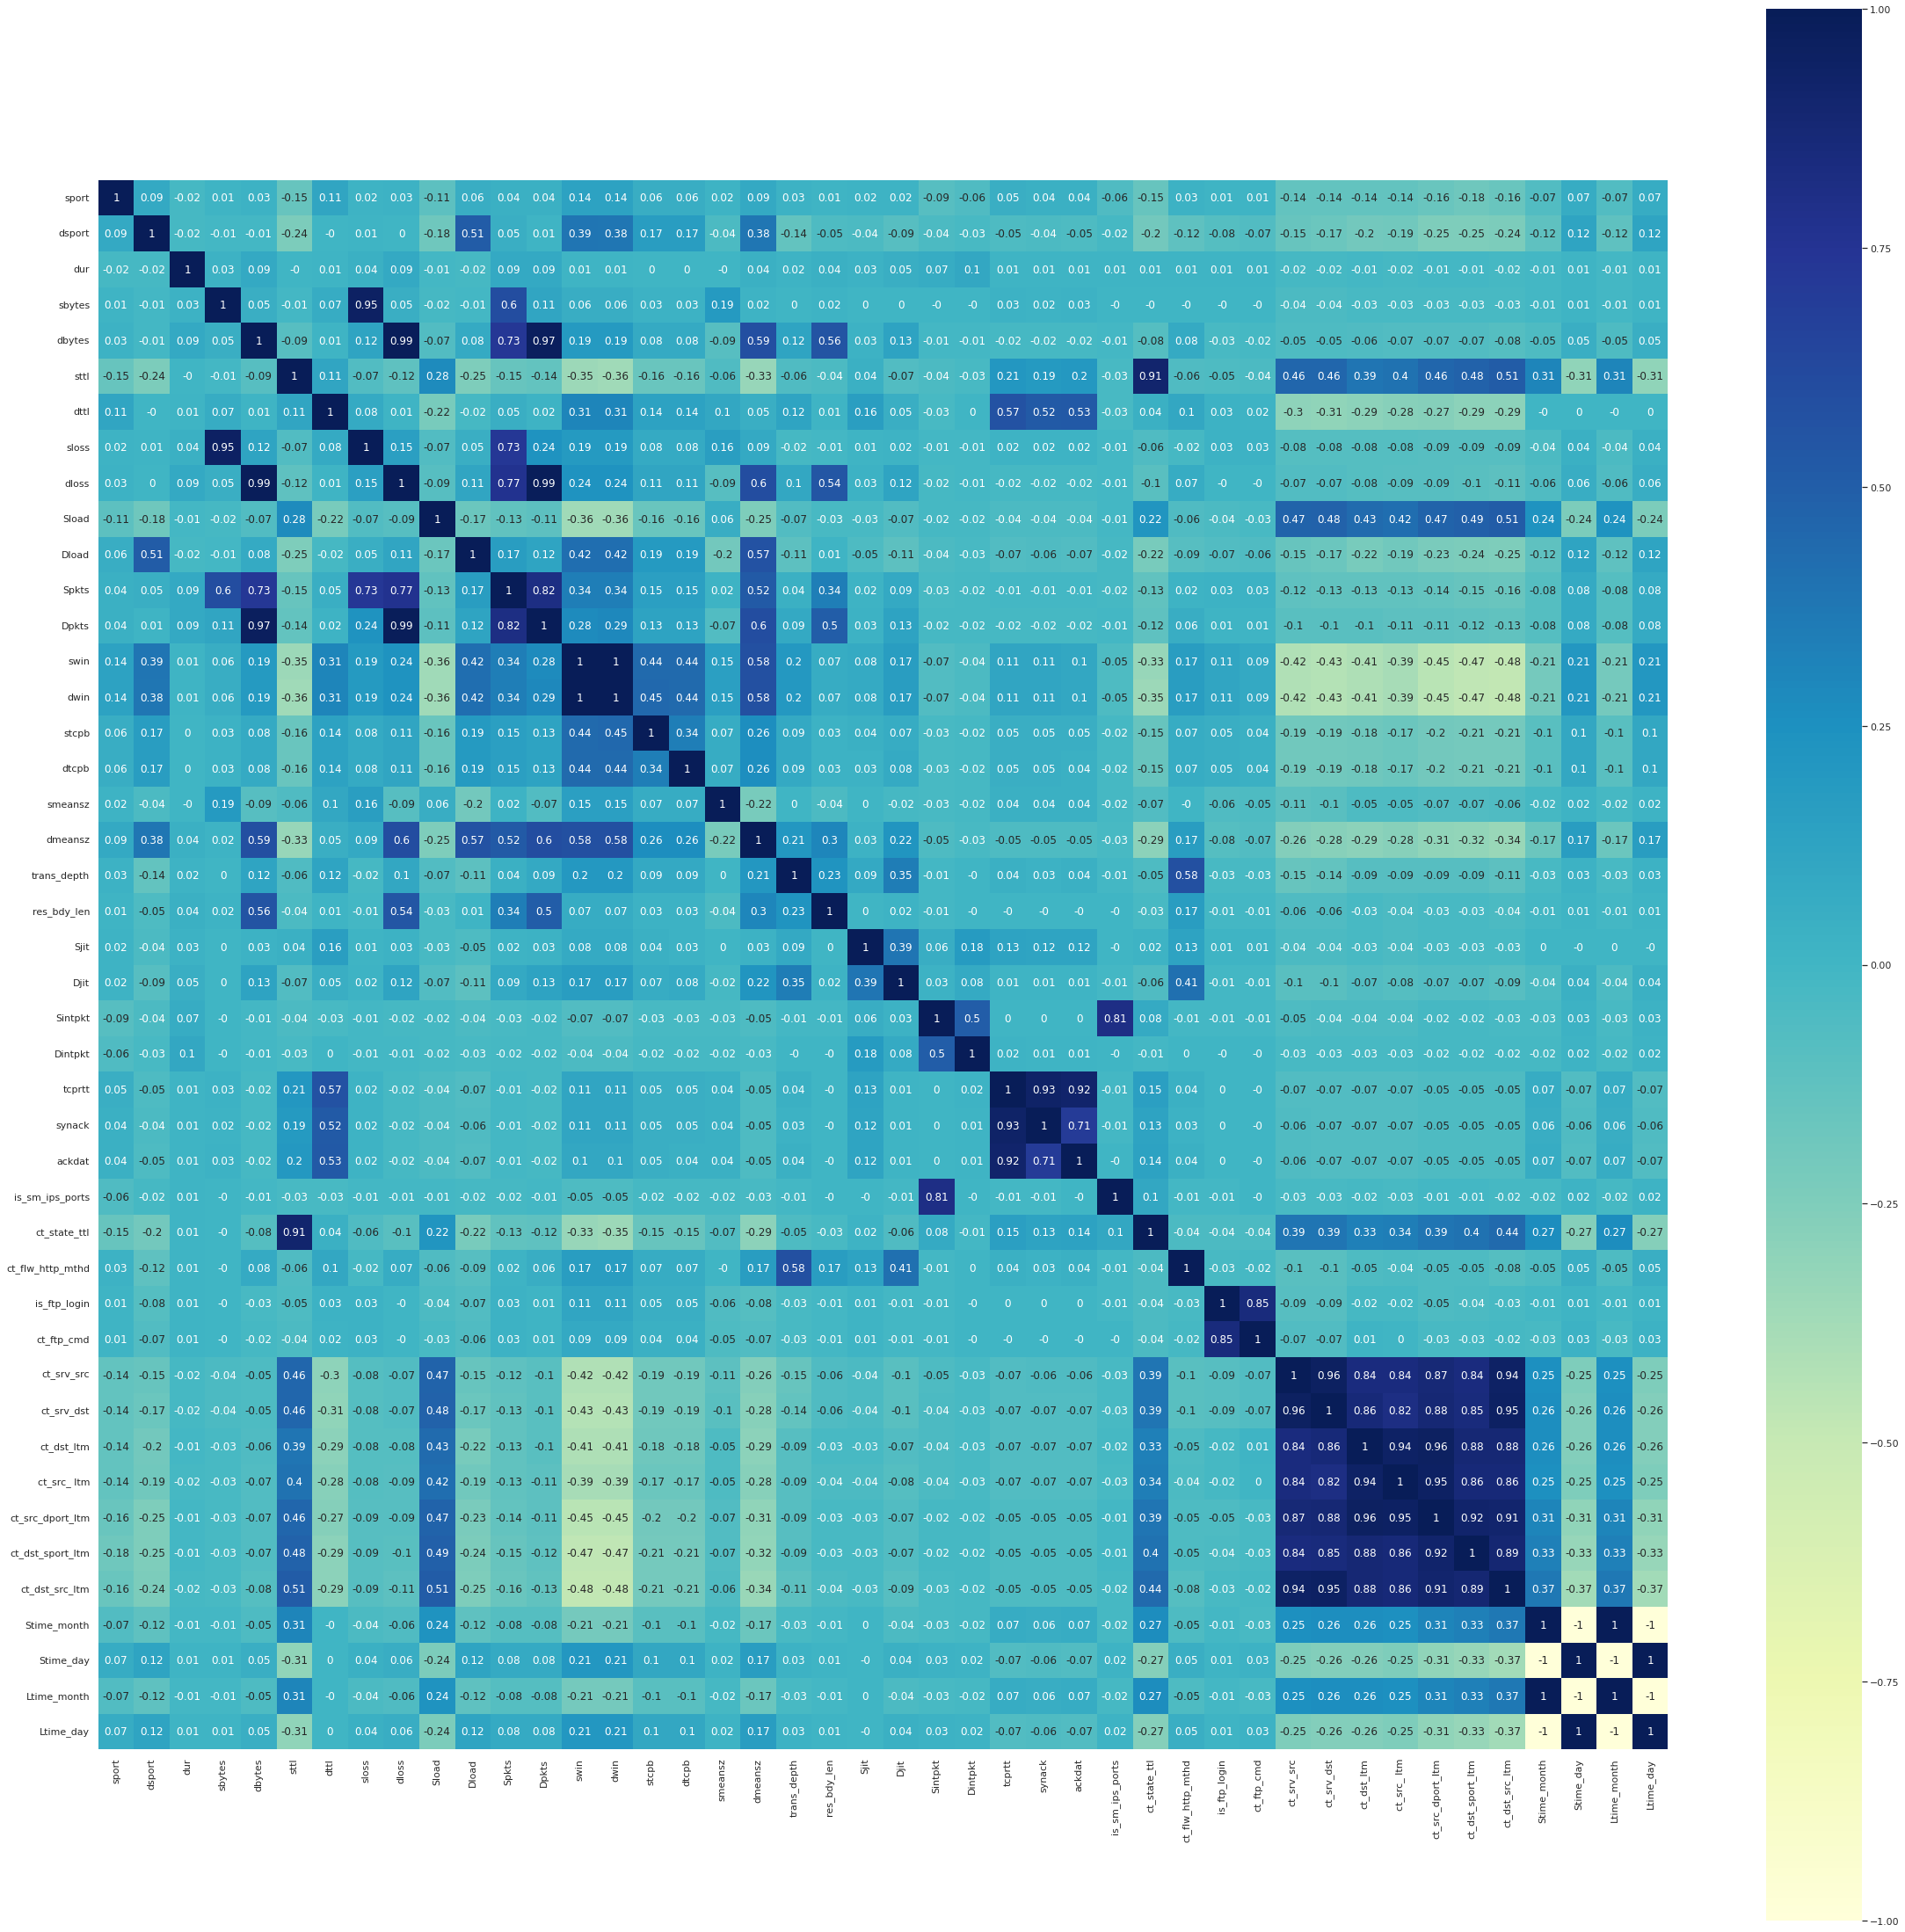

In [72]:
sns.set(rc = {'figure.figsize':(40,40)})
sns.heatmap(np.round(corr_mat_df, 2),annot=True,cmap='YlGnBu', square=True)

### Feature selection with PCA

In [73]:
feature_list = [col for col in df.columns if col != 'Label' and col != 'attack_cat_idx']
vecAssembler = VectorAssembler(inputCols=feature_list ,outputCol="features")
df = vecAssembler.transform(df)

In [74]:
print(feature_list)

['sport', 'dsport', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'proto_vec', 'state_vec', 'service_vec', 'srcip_vec', 'dstip_vec', 'Stime_month', 'Stime_day', 'Ltime_month', 'Ltime_day']


In [75]:
output_dat = df.select('features', 'Label', 'attack_cat_idx')
#since all the features don't use the same unit, we need to scale our features
scaler = StandardScaler(inputCol="features", outputCol="Features_scaled", withStd=False, withMean=True)

#Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(output_dat)

# Normalize each feature to have unit standard deviation.
scaledData = scalerModel.transform(output_dat)
scaledData.select(['Features_scaled']).show(5, truncate = False) # sample centered data

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [76]:
df_pca = scaledData
pca = PCA(k=50, inputCol=scaler.getOutputCol(), outputCol="features_pca")
pca_model=pca.fit(df_pca)
pca_comp = pca_model.transform(df_pca)
pca_comp.show(5, truncate=False)

22/01/09 02:04:48 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/01/09 02:04:48 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+--------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Variances (Percentage):
[6.5520739e+01 3.2595502e+01 1.8814440e+00 2.3110000e-03 4.0000000e-06
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]



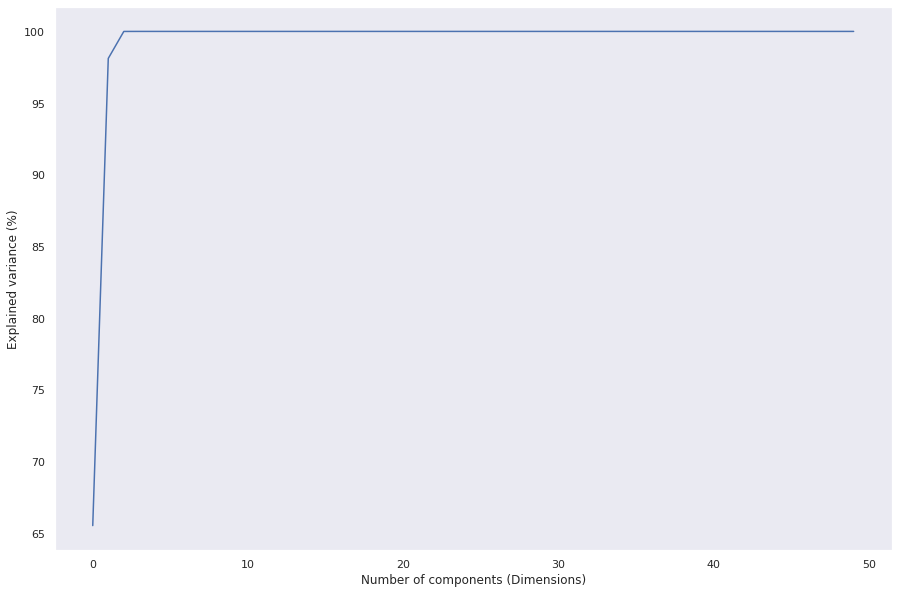

In [77]:
# Get explained variances
print("Variances (Percentage):")
print(np.round(pca_model.explainedVariance.toArray() * 100, 6))   #.explained_variance_ratio_ * 100)
print()

# Make the scree plot
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
plt.plot(np.cumsum(pca_model.explainedVariance.toArray() * 100))
plt.grid(True)

plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")
plt.grid()
plt.show()

In [78]:
#from the above figure, we can see that only 3 variables can exlain more than 95 percent 
# so we rerun pca with three variables only this time
df_pca = scaledData
pca = PCA(k=8, inputCol=scaler.getOutputCol(), outputCol="features_pca")
pca_model=pca.fit(df_pca)
pca_comp = pca_model.transform(df_pca)
pca_comp.show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+--------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [79]:
df_ml = pca_comp.select('features_pca', 'Label', 'attack_cat_idx')
df_ml.show(5)

+--------------------+-----+--------------+
|        features_pca|Label|attack_cat_idx|
+--------------------+-----+--------------+
|[4.44234888513529...|    0|           0.0|
|[-2.3595885420881...|    0|           0.0|
|[-3.9680392757226...|    0|           0.0|
|[4.44231908494554...|    0|           0.0|
|[4.30261356793815...|    0|           0.0|
+--------------------+-----+--------------+
only showing top 5 rows



In [80]:
#split training and testing dataset
train, test = df_ml.randomSplit([0.75, 0.25], seed=17)
print(f"Size of train Dataset : {train.count()}")
print(f"Size of test Dataset : {test.count()}")

Size of train Dataset : 1905421


Size of test Dataset : 634318


### Binary Classification

In [81]:
#Feature distribution
data = df.groupBy('Label').count().toPandas()
data.head()

,Label,count
0,1,321283
1,0,2218456


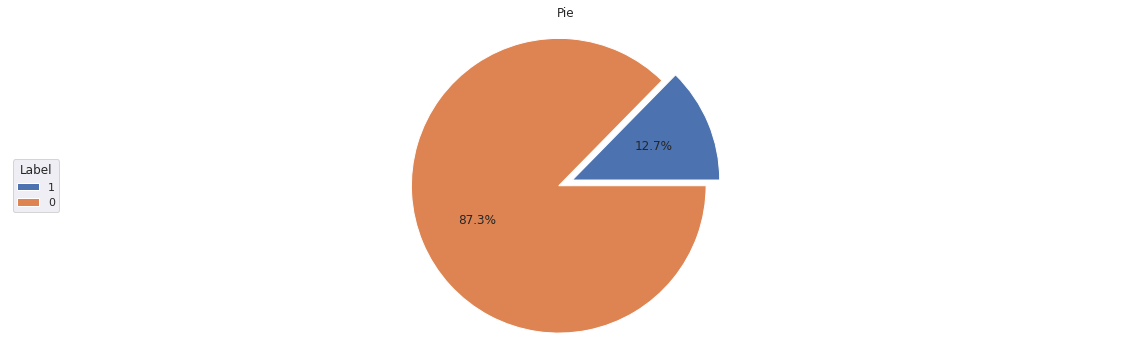

In [82]:
fig = plt.figure(figsize=(20,6))
ax3 = fig.subplots()
ax3.pie(data['count'], explode=data['count']/(data['count'].sum()*10), autopct="%1.1f%%")
ax3.legend(title="Label", labels=data['Label'], loc='center left')
ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Pie")

plt.show()

The dataset is unbalanced 

### Logistic Regression

In [83]:
lr = LogisticRegression(featuresCol="features_pca", labelCol="Label", family="binomial")
lr_model = lr.fit(train)
print( lr_model.coefficients)

[3.11314409102622e-08,5.826684854516014e-11,-9.962000492963052e-08,2.1380353116154398e-05,-4.060049808290876e-06,4.284529561577246e-07,-4.2446693043697815e-08,9.437493912817864e-06]


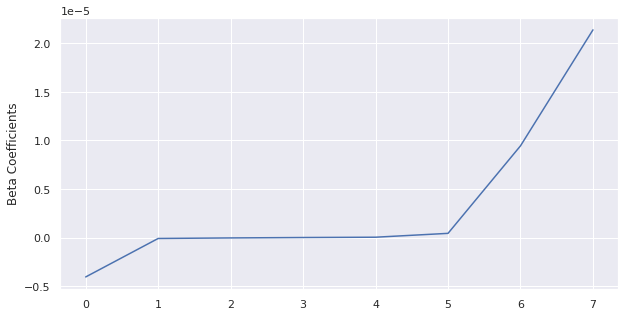

In [84]:
fig = plt.figure(figsize=(10,5))
beta = np.sort(lr_model.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [85]:
#model evaluation
lr_summary=lr_model.summary
print("accuracy", lr_summary.accuracy)
print("areaUnderROC", lr_summary.areaUnderROC)
print("weightedRecall",lr_summary.weightedRecall)
print("weightedPrecision",lr_summary.weightedPrecision)

accuracy 0.9036433418126493


areaUnderROC 0.9339237945551485
weightedRecall 0.9036433418126493
weightedPrecision 0.8943807941969346


/app/spark-3.2.0-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


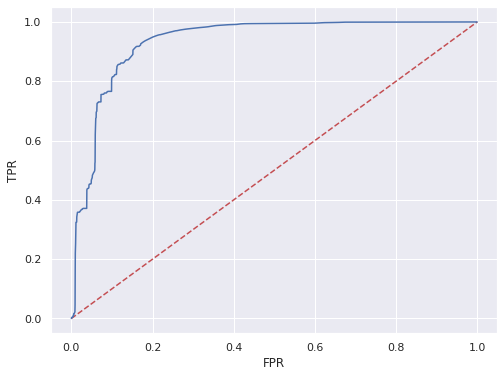

In [86]:
plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(lr_summary.roc.select('FPR').collect(), lr_summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

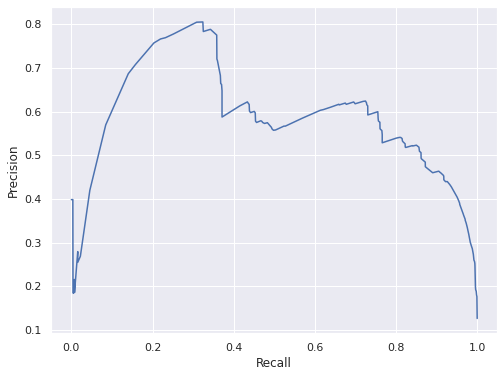

In [87]:
plt.figure(figsize=(8,6))
pr = lr_summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [88]:
lr_summary.predictions.show()

/app/spark-3.2.0-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+--------------------+-----+--------------+--------------------+--------------------+----------+
|        features_pca|Label|attack_cat_idx|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------+--------------------+--------------------+----------+
|[-2.5905358554557...|  0.0|           0.0|[93.0955580365141...|           [1.0,0.0]|       0.0|
|[-2.5902699314999...|  0.0|           0.0|[5.33161585690721...|[0.99518702772362...|       0.0|
|[-2.5901835439810...|  0.0|           0.0|[4.44177182980812...|[0.98836198169528...|       0.0|
|[-2.5901172103287...|  0.0|           0.0|[175.919256935029...|           [1.0,0.0]|       0.0|
|[-2.5899980375331...|  0.0|           0.0|[172.465699290722...|           [1.0,0.0]|       0.0|
|[-2.5898626183794...|  0.0|           0.0|[4.32475490797435...|[0.98693612982580...|       0.0|
|[-2.5897455044360...|  0.0|           0.0|[358.253569258306...|           [1.0,0.0]|       0.0|
|[-2.5896255897792...|  0.0|  

### Evaluating performance on test

In [89]:
model_predictions = lr_model.transform(test)
print('model_predictions', model_predictions.columns)

model_predictions ['features_pca', 'Label', 'attack_cat_idx', 'rawPrediction', 'probability', 'prediction']


In [90]:
model_predictions.select(['label','probability','prediction']).show(20,False)

+-----+-----------------------------------------+----------+
|label|probability                              |prediction|
+-----+-----------------------------------------+----------+
|0    |[1.0,0.0]                                |0.0       |
|0    |[1.0,0.0]                                |0.0       |
|0    |[0.9825318626385829,0.017468137361417058]|0.0       |
|0    |[1.0,0.0]                                |0.0       |
|0    |[1.0,0.0]                                |0.0       |
|0    |[0.9602054824802756,0.039794517519724404]|0.0       |
|0    |[0.9819117270442432,0.018088272955756768]|0.0       |
|0    |[0.9759033022302749,0.024096697769725117]|0.0       |
|0    |[0.9612864045646161,0.038713595435383885]|0.0       |
|0    |[1.0,0.0]                                |0.0       |
|0    |[0.9999999674161433,3.258385672388897E-8]|0.0       |
|0    |[0.9855356307587669,0.014464369241233066]|0.0       |
|0    |[0.9821818335416869,0.017818166458313134]|0.0       |
|0    |[1.0,0.0]        

In [91]:
lr_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
lr_evaluator.setLabelCol("Label")
lr_auroc = lr_evaluator.evaluate(model_predictions)
print(f'The auroc value of Logistic Regression Model is {lr_auroc}')
lr_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
lr_evaluator.setLabelCol("Label")
lr_aupr = lr_evaluator.evaluate(model_predictions)
print(f'The aupr value of Logistic Regression Model is {lr_aupr}')

true_pos=model_predictions.filter(model_predictions['Label']==1).filter(model_predictions['prediction']==1).count()
actual_pos=model_predictions.filter(model_predictions['Label']==1).count()
pred_pos=model_predictions.filter(model_predictions['prediction']==1).count()

print(float(true_pos)/(actual_pos))
print(float(true_pos)/(pred_pos))

The auroc value of Logistic Regression Model is 0.9333649186193996


The aupr value of Logistic Regression Model is 0.5836544410008543


0.3295955997249828
0.781562175781829


In [92]:
true_false=model_predictions.filter(model_predictions['Label']==0).filter(model_predictions['prediction']==0).count()
actual_false=model_predictions.filter(model_predictions['Label']==0).count()
pred_false=model_predictions.filter(model_predictions['prediction']==0).count()
print(actual_false, true_false, pred_false)

554323 546954 600583


In [93]:
false_pos = model_predictions.filter(model_predictions['Label']==0).filter(model_predictions['prediction']==1).count()
true_neg = model_predictions.filter(model_predictions['Label']==0).filter(model_predictions['prediction']==0).count()
false_neg = model_predictions.filter(model_predictions['Label']==1).filter(model_predictions['prediction']==0).count()

In [94]:
print("Accuracy : ", (true_pos + true_neg) / (true_pos+true_neg+false_pos+false_neg))
print("Precision :", true_pos / (true_pos + false_pos))
print("recall: ", true_pos / (true_pos + false_neg))

Accuracy :  0.9038368767715877
Precision : 0.781562175781829
recall:  0.3295955997249828


### Decision Tree Classifier

In [95]:
dt = DecisionTreeClassifier()
dt.setFeaturesCol("features_pca")
dt.setLabelCol("Label")
dt_model = dt.fit(train)
model_predictions = dt_model.transform(test)
model_predictions.select(['label','probability','prediction']).show(10,False)

22/01/09 02:33:03 WARN MemoryStore: Not enough space to cache rdd_869_3 in memory! (computed 41.9 MiB so far)
22/01/09 02:33:03 WARN BlockManager: Persisting block rdd_869_3 to disk instead.
22/01/09 02:33:03 WARN MemoryStore: Not enough space to cache rdd_869_2 in memory! (computed 18.4 MiB so far)
22/01/09 02:33:03 WARN BlockManager: Persisting block rdd_869_2 to disk instead.


+-----+-----------------------------------------+----------+
|label|probability                              |prediction|
+-----+-----------------------------------------+----------+
|0    |[0.9993708540630183,6.291459369817579E-4]|0.0       |
|0    |[0.9181662691816627,0.08183373081833731] |0.0       |
|0    |[0.9181662691816627,0.08183373081833731] |0.0       |
|0    |[0.9993708540630183,6.291459369817579E-4]|0.0       |
|0    |[0.9993708540630183,6.291459369817579E-4]|0.0       |
|0    |[0.9181662691816627,0.08183373081833731] |0.0       |
|0    |[0.9181662691816627,0.08183373081833731] |0.0       |
|0    |[0.9181662691816627,0.08183373081833731] |0.0       |
|0    |[0.9181662691816627,0.08183373081833731] |0.0       |
|0    |[0.9181662691816627,0.08183373081833731] |0.0       |
+-----+-----------------------------------------+----------+
only showing top 10 rows



### Evaluating the model

In [96]:
dt_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
dt_evaluator.setLabelCol('Label')
dt_auroc = dt_evaluator.evaluate(model_predictions)

In [97]:
print(f'The auc value of Decision Tree Classifier Model is {dt_auroc}')
dt_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
dt_evaluator.setLabelCol('Label')
dt_aupr = dt_evaluator.evaluate(model_predictions)
print(f'The aupr value of Decision Tree Model is {dt_aupr}')
true_pos=model_predictions.filter(model_predictions['Label']==1).filter(model_predictions['prediction']==1).count()
actual_pos=model_predictions.filter(model_predictions['Label']==1).count()
pred_pos=model_predictions.filter(model_predictions['prediction']==1).count()

The auc value of Decision Tree Classifier Model is 0.8796700818902973


The aupr value of Decision Tree Model is 0.6963228194596718


In [98]:
print(float(true_pos)/(actual_pos))
print(float(true_pos)/(pred_pos))

0.7268829301831364
0.9468344948869928


In [99]:
false_pos = model_predictions.filter(model_predictions['Label']==0).filter(model_predictions['prediction']==1).count()
true_neg = model_predictions.filter(model_predictions['Label']==0).filter(model_predictions['prediction']==0).count()
false_neg = model_predictions.filter(model_predictions['Label']==1).filter(model_predictions['prediction']==0).count()

In [100]:
print("Accuracy : ", (true_pos + true_neg) / (true_pos+true_neg+false_pos+false_neg))
print("Precision :", true_pos / (true_pos + false_pos))
print("recall: ", true_pos / (true_pos + false_neg))

Accuracy :  0.9604094476272154
Precision : 0.9468344948869928
recall:  0.7268829301831364


### Multi-class classification

In [101]:
data = df_ml.groupBy('attack_cat_idx').count().toPandas()
data 

,attack_cat_idx,count
0,8.0,1511
1,0.0,2218456
2,7.0,2329
3,1.0,215481
4,4.0,16353
5,3.0,24246
6,2.0,44525
7,6.0,2677
8,5.0,13987
9,9.0,174


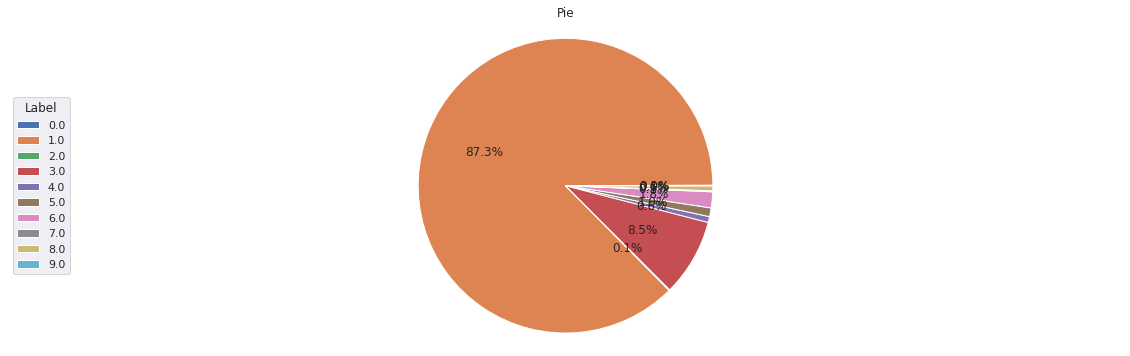

In [102]:
fig = plt.figure(figsize=(20,6))

ax3 = fig.subplots()
ax3.pie(data['count'], autopct="%1.1f%%")
ax3.legend(title="Label", labels=data['attack_cat_idx'].sort_values(ascending=True), loc='center left')
ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Pie")

plt.show()

### Logistic Regression

In [103]:
lr = LogisticRegression(featuresCol="features_pca", labelCol="attack_cat_idx", family="multinomial", 
                        regParam=0.1, elasticNetParam=0.1)

# Fit the model
lrModel = lr.fit(train)

# Print the coefficients and intercept for multinomial logistic regression
print("Coefficients: \n" + str(lrModel.coefficientMatrix))
print("Intercept: " + str(lrModel.interceptVector))

trainingSummary = lrModel.summary

# for multiclass, we can inspect metrics on a per-label basis
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Coefficients: 
10 X 8 CSCMatrix
(0,0) -0.0
(1,0) 0.0
(0,1) 0.0
(1,2) -0.0
(0,3) -0.0
(1,3) 0.0
(0,4) -0.0
(0,5) -0.0
(1,6) 0.0
Intercept: [5.159861707694668,2.711936131511345,1.2045468309125873,0.5948620189450694,0.2099064804848435,0.04380129902800966,-1.6121663377852464,-1.739818227683871,-2.1865875436545257,-4.38634235945288]
False positive rate by label:


label 0: 0.9988395610225125
label 1: 0.00022599284853087442
label 2: 0.0
label 3: 0.0
label 4: 0.0
label 5: 0.0
label 6: 0.0
label 7: 0.0
label 8: 0.0
label 9: 0.0
True positive rate by label:
label 0: 0.9999074593196577
label 1: 0.0002469090078578792
label 2: 0.0
label 3: 0.0
label 4: 0.0
label 5: 0.0
label 6: 0.0
label 7: 0.0
label 8: 0.0
label 9: 0.0
Precision by label:
label 0: 0.8734857508213967
label 1: 0.09216589861751152
label 2: 0.0
label 3: 0.0
label 4: 0.0
label 5: 0.0
label 6: 0.0
label 7: 0.0
label 8: 0.0
label 9: 0.0
Recall by label:
label 0: 0.9999074593196577
label 1: 0.0002469090078578792
label 2: 0.0
label 3: 0.0
label 4: 0.0
label 5: 0.0
label 6: 0.0
label 7: 0.0
label 8: 0.0
label 9: 0.0
F-measure by label:
label 0: 0.9324309633747254
label 1: 0.0004924986302381846
label 2: 0.0
label 3: 0.0
label 4: 0.0
label 5: 0.0
label 6: 0.0
label 7: 0.0
label 8: 0.0
label 9: 0.0
Accuracy: 0.8733077886724246
FPR: 0.872373342543468
TPR: 0.8733077886724246
F-measure: 0.81439688269

In [104]:
trainingSummary.predictions.filter(F.col('attack_cat_idx') != 0.0).sample(0.005, 100).show(10)

/app/spark-3.2.0-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+--------------------+-----+--------------+--------------------+--------------------+----------+
|        features_pca|Label|attack_cat_idx|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------+--------------------+--------------------+----------+
|[-1.9562145920877...|    1|           5.0|[5.21271921975122...|[0.91434596290217...|       0.0|
|[-1.7852581837780...|    1|           2.0|[5.37394652779464...|[0.92580958294727...|       0.0|
|[-1.6791226196779...|    1|           2.0|[5.23239163271315...|[0.91305502198356...|       0.0|
|[-1.5787317528485...|    1|           5.0|[5.29452331112349...|[0.91733252743208...|       0.0|
|[-1.4744379872957...|    1|           2.0|[5.20912886879076...|[0.90856961674335...|       0.0|
|[-1.2879174203943...|    1|           2.0|[5.38917657492220...|[0.92206473828589...|       0.0|
|[-1.1208671981182...|    1|           2.0|[5.41602700920816...|[0.92250083511348...|       0.0|
|[-1.1178468346297...|    1|  

In [114]:
predictions = lrModel.transform(test)

In [115]:
predictions.filter(predictions['attack_cat_idx'] == 2).orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+-----+--------------+------------------------------+------------------------------+----------+
|                  features_pca|Label|attack_cat_idx|                 rawPrediction|                   probability|prediction|
+------------------------------+-----+--------------+------------------------------+------------------------------+----------+
|[-2.044959312548462E9,-2.03...|    1|           2.0|[5.684484320873468,2.118847...|[0.9476749082445999,0.02679...|       0.0|
|[-2.47148069866321E9,-8.272...|    1|           2.0|[5.626644988803482,2.012069...|[0.947447522724246,0.025513...|       0.0|
|[-2.4222535756558576E9,9.99...|    1|           2.0|[5.608935928761449,2.028281...|[0.9461575677972183,0.02635...|       0.0|
|[-2.2744031257271185E9,-1.9...|    1|           2.0|[5.625374827822751,2.062006...|[0.9461467238432295,0.02681...|       0.0|
|[-2.3841331982811537E9,1.71...|    1|           2.0|[5.59845097038483,2.0400637...|[0.9453226612361474,0.02692

In [116]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='attack_cat_idx')
print(evaluator.evaluate(predictions))

0.8151308214324101


In [117]:
preds_and_labels = predictions.select(['prediction','attack_cat_idx']).withColumn('attack_cat_idx', F.col('attack_cat_idx').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','attack_cat_idx'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

[[5.54268e+05 5.50000e+01 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [5.34660e+04 1.20000e+01 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [1.11540e+04 8.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [6.05300e+03 6.00000e+01 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [4.00700e+03 7.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [3.53600e+03 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [6.82000e+02 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [5.73000e+02 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]


In [118]:
print("metrics.falsePositiveRate")
for i in [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]:
    print("Label: ", i, " : ", metrics.falsePositiveRate(i))
print("metrics.precision")
for i in [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]:
    print("Label: ", i, " : ", metrics.precision(i))
print("metrics.recall")
for i in [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]:
    print("Label: ", i, " : ", metrics.recall(i))
    
print("accuracy", metrics.accuracy)
print("weightedFalsePositiveRate", metrics.weightedFalsePositiveRate)
print("weightedPrecision", metrics.weightedPrecision)
print("weightedRecall", metrics.weightedRecall)
print("weightedFMeasure", metrics.weightedFMeasure())

metrics.falsePositiveRate
Label:  0.0  :  0.9988999312457029
Label:  1.0  :  0.00022553543144411542
Label:  2.0  :  0.0
Label:  3.0  :  0.0
Label:  4.0  :  0.0
Label:  5.0  :  0.0
Label:  6.0  :  0.0
Label:  7.0  :  0.0
Label:  8.0  :  0.0
Label:  9.0  :  0.0
metrics.precision
Label:  0.0  :  0.8739985019907754
Label:  1.0  :  0.08391608391608392
Label:  2.0  :  0.0
Label:  3.0  :  0.0
Label:  4.0  :  0.0
Label:  5.0  :  0.0
Label:  6.0  :  0.0
Label:  7.0  :  0.0
Label:  8.0  :  0.0
Label:  9.0  :  0.0
metrics.recall
Label:  0.0  :  0.9999007798702201
Label:  1.0  :  0.00022439133849433412
Label:  2.0  :  0.0
Label:  3.0  :  0.0
Label:  4.0  :  0.0
Label:  5.0  :  0.0
Label:  6.0  :  0.0
Label:  7.0  :  0.0
Label:  8.0  :  0.0
Label:  9.0  :  0.0
accuracy 0.8738203866199603
weightedFalsePositiveRate 0.8729458532971073
weightedPrecision 0.7708517430605737
weightedRecall 0.8738203866199604
weightedFMeasure 0.8151308214324101


### Random Forest Classifier

In [108]:
rf = RandomForestClassifier(numTrees=3, maxDepth=2,featuresCol="features_pca", labelCol="attack_cat_idx",seed=42)
rf.getMinWeightFractionPerNode()
model = rf.fit(train)

22/01/09 02:51:18 WARN MemoryStore: Not enough space to cache rdd_1071_2 in memory! (computed 17.6 MiB so far)
22/01/09 02:51:18 WARN BlockManager: Persisting block rdd_1071_2 to disk instead.
22/01/09 02:51:18 WARN MemoryStore: Not enough space to cache rdd_1071_3 in memory! (computed 17.6 MiB so far)
22/01/09 02:51:18 WARN BlockManager: Persisting block rdd_1071_3 to disk instead.


In [109]:
predictions = model.transform(test)
predictions.show(25)

+--------------------+-----+--------------+--------------------+--------------------+----------+
|        features_pca|Label|attack_cat_idx|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------+--------------------+--------------------+----------+
|[-2.5906248240952...|    0|           0.0|[2.84296634885186...|[0.94765544961728...|       0.0|
|[-2.5899437280154...|    0|           0.0|[2.84296634885186...|[0.94765544961728...|       0.0|
|[-2.5892963147730...|    0|           0.0|[2.84296634885186...|[0.94765544961728...|       0.0|
|[-2.5892946642536...|    0|           0.0|[2.84296634885186...|[0.94765544961728...|       0.0|
|[-2.5883416170011...|    0|           0.0|[2.84296634885186...|[0.94765544961728...|       0.0|
|[-2.5881687125096...|    0|           0.0|[2.84296634885186...|[0.94765544961728...|       0.0|
|[-2.5877757551464...|    0|           0.0|[2.84296634885186...|[0.94765544961728...|       0.0|
|[-2.5876892133731...|    0|  

In [110]:
evaluator = MulticlassClassificationEvaluator(labelCol="attack_cat_idx", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 0.872198541555215
Test Error = 0.12780145844478497


In [111]:
preds_and_labels = predictions.select(['prediction','attack_cat_idx']).withColumn('attack_cat_idx', F.col('attack_cat_idx').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','attack_cat_idx'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

[[5.53222e+05 1.10100e+03 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [3.42530e+04 1.92250e+04 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [9.26200e+03 1.90000e+03 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [5.75900e+03 3.54000e+02 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [2.57700e+03 1.43700e+03 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [3.26700e+03 2.69000e+02 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [4.33000e+02 2.49000e+02 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [3.30000e+02 2.43000e+02 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]


In [112]:
print("metrics.falsePositiveRate")
for i in [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]:
    print("Label: ", i, " : ", metrics.falsePositiveRate(i))
print("metrics.precision")
for i in [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]:
    print("Label: ", i, " : ", metrics.precision(i))
print("metrics.recall")
for i in [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]:
    print("Label: ", i, " : ", metrics.recall(i))
    
print("accuracy", metrics.accuracy)
print("weightedFalsePositiveRate", metrics.weightedFalsePositiveRate)
print("weightedPrecision", metrics.weightedPrecision)
print("weightedRecall", metrics.weightedRecall)
print("weightedFMeasure", metrics.weightedFMeasure())

metrics.falsePositiveRate
Label:  0.0  :  0.7040190011875742
Label:  1.0  :  0.009560291990909717
Label:  2.0  :  0.0
Label:  3.0  :  0.0
Label:  4.0  :  0.0
Label:  5.0  :  0.0
Label:  6.0  :  0.0
Label:  7.0  :  0.0
Label:  8.0  :  0.0
Label:  9.0  :  0.0
metrics.precision
Label:  0.0  :  0.9076057354726516
Label:  1.0  :  0.7758899023327145
Label:  2.0  :  0.0
Label:  3.0  :  0.0
Label:  4.0  :  0.0
Label:  5.0  :  0.0
Label:  6.0  :  0.0
Label:  7.0  :  0.0
Label:  8.0  :  0.0
Label:  9.0  :  0.0
metrics.recall
Label:  0.0  :  0.9980137934020418
Label:  1.0  :  0.3594936235461311
Label:  2.0  :  0.0
Label:  3.0  :  0.0
Label:  4.0  :  0.0
Label:  5.0  :  0.0
Label:  6.0  :  0.0
Label:  7.0  :  0.0
Label:  8.0  :  0.0
Label:  9.0  :  0.0
accuracy 0.9024605954741943
weightedFalsePositiveRate 0.6160398886526783
weightedPrecision 0.8585595463180227
weightedRecall 0.9024605954741943
weightedFMeasure 0.872198541555215
